In [1]:
from DCC import *
from Utils import *
from Plots import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import defaultdict
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import shap
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import boxcox
from scipy.special import inv_boxcox


boxcox_transform = True

init_plotting()

dataset2name = {
    "Bala_classification_dataset.csv": "Bala Classification",
    "Bala_regression_dataset.csv": "Bala Regression",
    "bandgap.csv": "Bandgap",
    "BMDS_data.csv": "BMDS",
    "Crystal_structure.csv": "Crystal Structure",
    "Glass.csv": "Glass",
    "PUE.csv": "PUE",
}

from enum import Enum
from sklearn.datasets import make_classification


class PerturbationType(Enum):
    Deletion = "Deletion"
    AdditionLinear = "AdditionLinear"
    AdditionRand = "AdditionRand"
    ReplacementLinear = "ReplacementLinear"
    ReplacementRand = "ReplacementRand"


eps = 1e-6

In [2]:
df = pd.read_csv("results/SHAP_results.csv")
df

dataset perturbation_type  perturbation_ratio  \
0     Bala_classification_dataset.csv          Deletion                0.05   
1     Bala_classification_dataset.csv          Deletion                0.05   
2     Bala_classification_dataset.csv          Deletion                0.05   
3     Bala_classification_dataset.csv          Deletion                0.05   
4     Bala_classification_dataset.csv          Deletion                0.05   
...                               ...               ...                 ...   
4615                          PUE.csv   ReplacementRand                0.15   
4616                          PUE.csv   ReplacementRand                0.15   
4617                          PUE.csv   ReplacementRand                0.15   
4618                          PUE.csv   ReplacementRand                0.15   
4619                          PUE.csv   ReplacementRand                0.15   

      SHAP_feat  SHAP_feat_ratio      max_shap_feat                      feat  \
0      0.031496         0.297431   Mendeleev_Number                  Compound   
1      0.027763         0.262175   Mendeleev_Number             x(BiMe1Me2)O3   
2      0.036863         0.348111   Mendeleev_Number                       Me1   
3      0.026647         0.251633   Mendeleev_Number                       Me2   
4      0.009097         0.085910   Mendeleev_Number                  frac-Me1   
...         ...              ...                ...                       ...   
4615   0.105647         1.000000  ZS_SS_VSA_EState8         ZS_SS_VSA_EState8   
4616   0.007102         0.067225  ZS_SS_VSA_EState8           ZS_SS_PEOE_VSA8   
4617   0.018134         0.171648  ZS_SS_VSA_EState8    ZS_log_HS_NumNHCO_norm   
4618   0.019256         0.182265  ZS_SS_VSA_EState8  ZS_FC_NumHAcceptors_norm   
4619   0.032851         0.310950  ZS_SS_VSA_EState8      ZS_FC_RingCount_norm   

      DCC_pearson_matrix  Corr_pearson_matrix  DCC_spearman_matrix  ...  \
0               1.000000            -0.100841             1.000000  ...   
1               0.928571            -0.395085             1.000000  ...   
2               0.928571            -0.094558             1.000000  ...   
3               0.928571            -0.246314             1.000000  ...   
4               1.000000             0.017028             1.000000  ...   
...                  ...                  ...                  ...  ...   
4615            0.571429            -0.532048             0.761905  ...   
4616            0.904762             0.226079             0.952381  ...   
4617            0.333333            -0.229745             0.619048  ...   
4618            0.714286             0.321769             0.809524  ...   
4619            0.666667            -0.169058             0.904762  ...   

      DCC_mutual_info_matrix  Corr_mutual_info_matrix  DCC_js_corr_matrix  \
0                   1.000000                 0.024555            1.000000   
1                   0.928571                 0.077559            1.000000   
2                   1.000000                 0.091084            1.000000   
3                   1.000000                 0.025397            1.000000   
4                   1.000000                 0.012468            1.000000   
...                      ...                      ...                 ...   
4615                0.761905                 0.186937            0.857143   
4616                0.904762                 0.137900            0.809524   
4617                0.952381                 0.102717            0.904762   
4618                0.952381                 0.130991            0.904762   
4619                0.952381                 0.115994            0.857143   

      Corr_js_corr_matrix  DCC_wd_corr_matrix  Corr_wd_corr_matrix  \
0                0.313147            1.000000             0.527515   
1                0.528265            1.000000             0.568063   
2                0.320797            1.000000             0.437985   
3 

In [3]:
# # drop 掉 columns max_shap_feat 等于 feat 的行
df = df[df["max_shap_feat"] != df["feat"]]
# # df = df[df["SHAP_feat_ratio"] >= 0.1]

d:\software\miniforge3\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


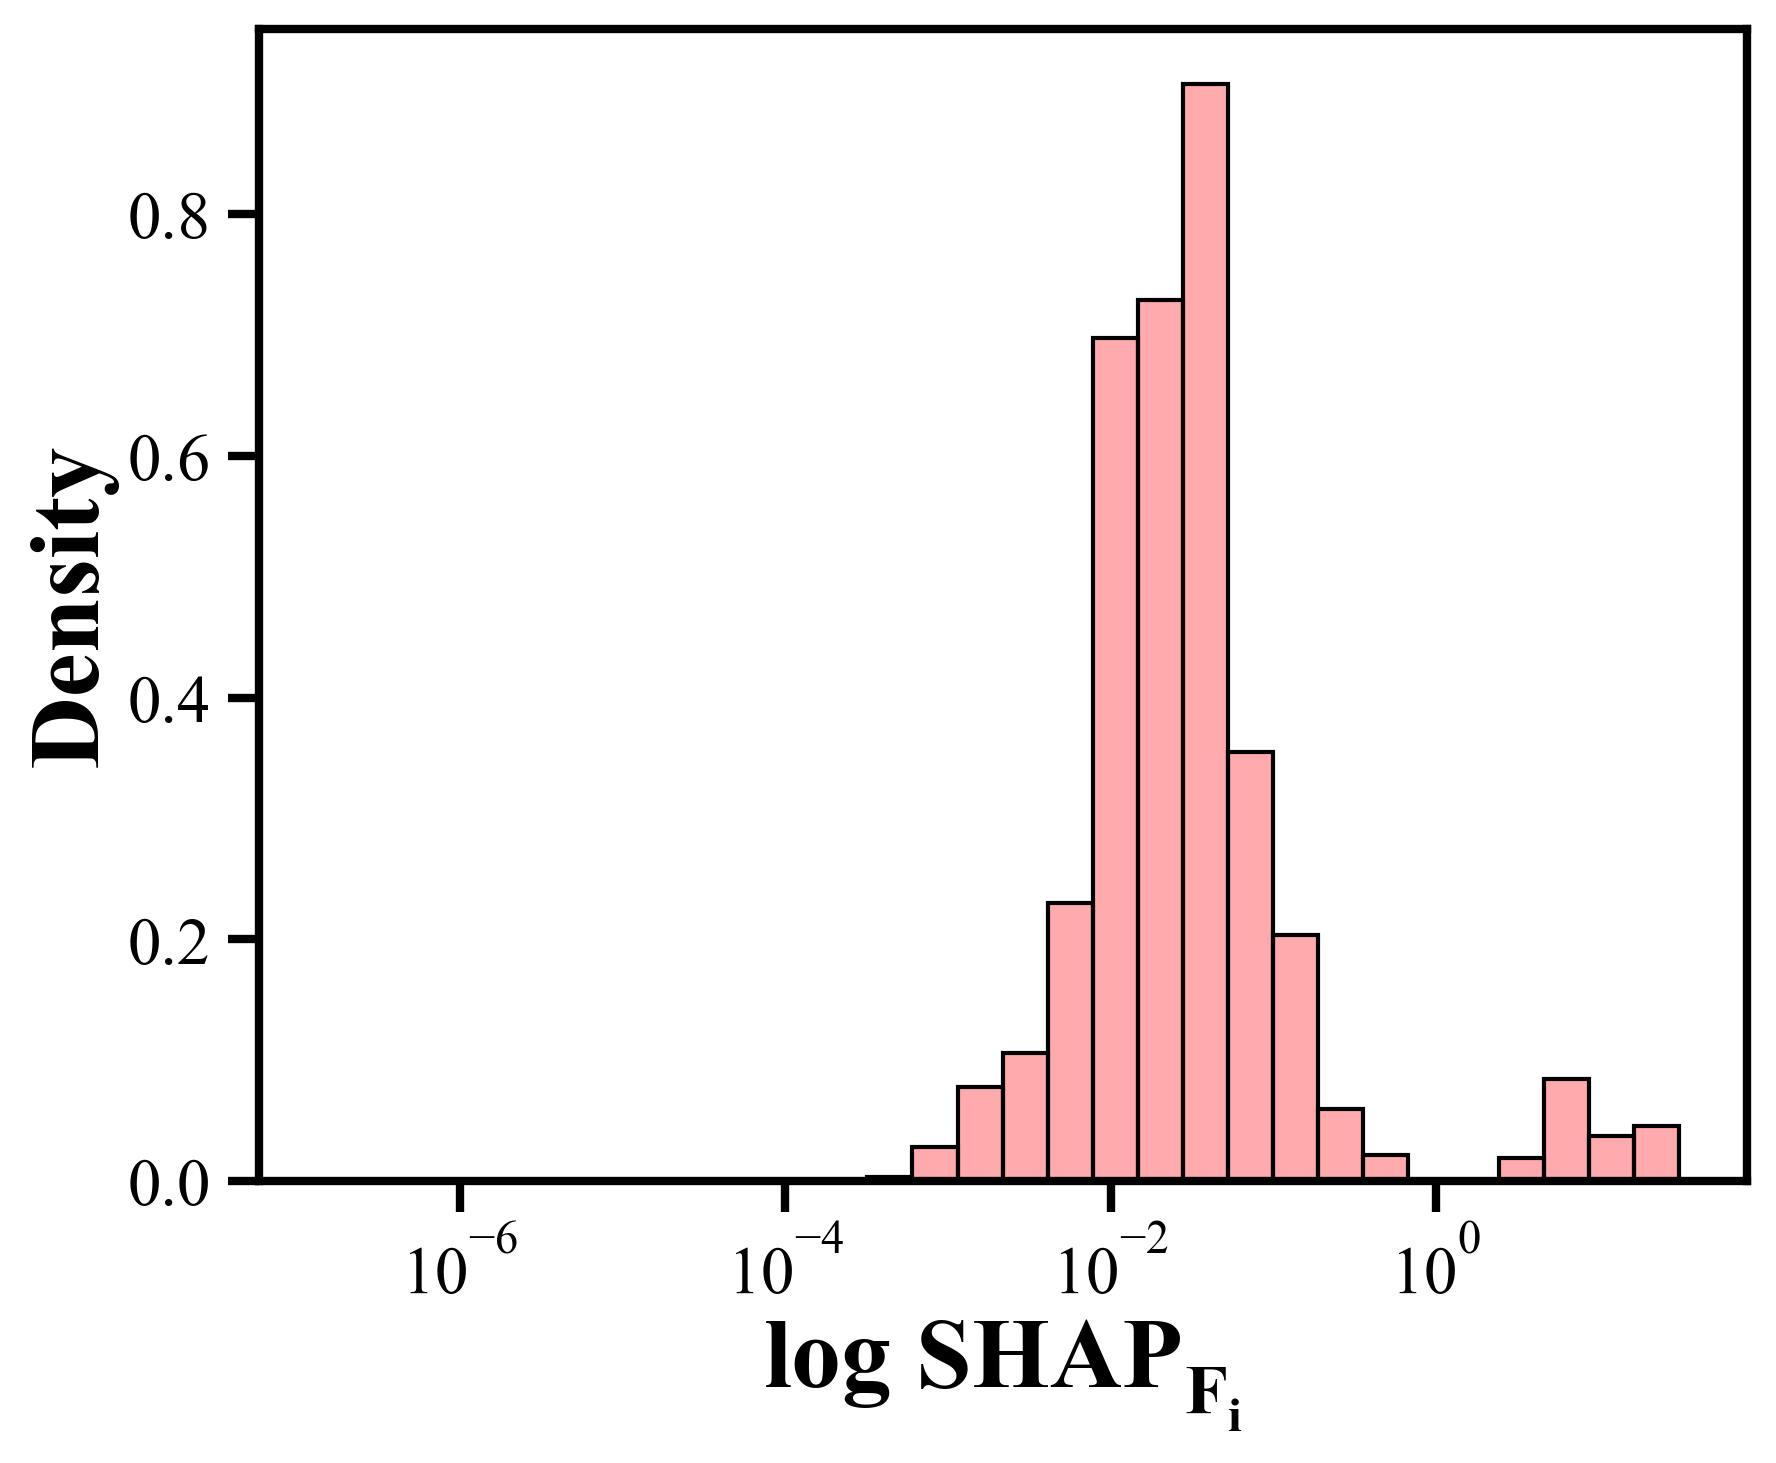

In [4]:
sns.histplot(df, x="SHAP_feat", kde=True, log_scale=True, stat="density", bins=30)
plt.xlabel(r"log $SHAP_{F_i}$")
plt.ylabel("Density")
plt.savefig("plots/shap_feat_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

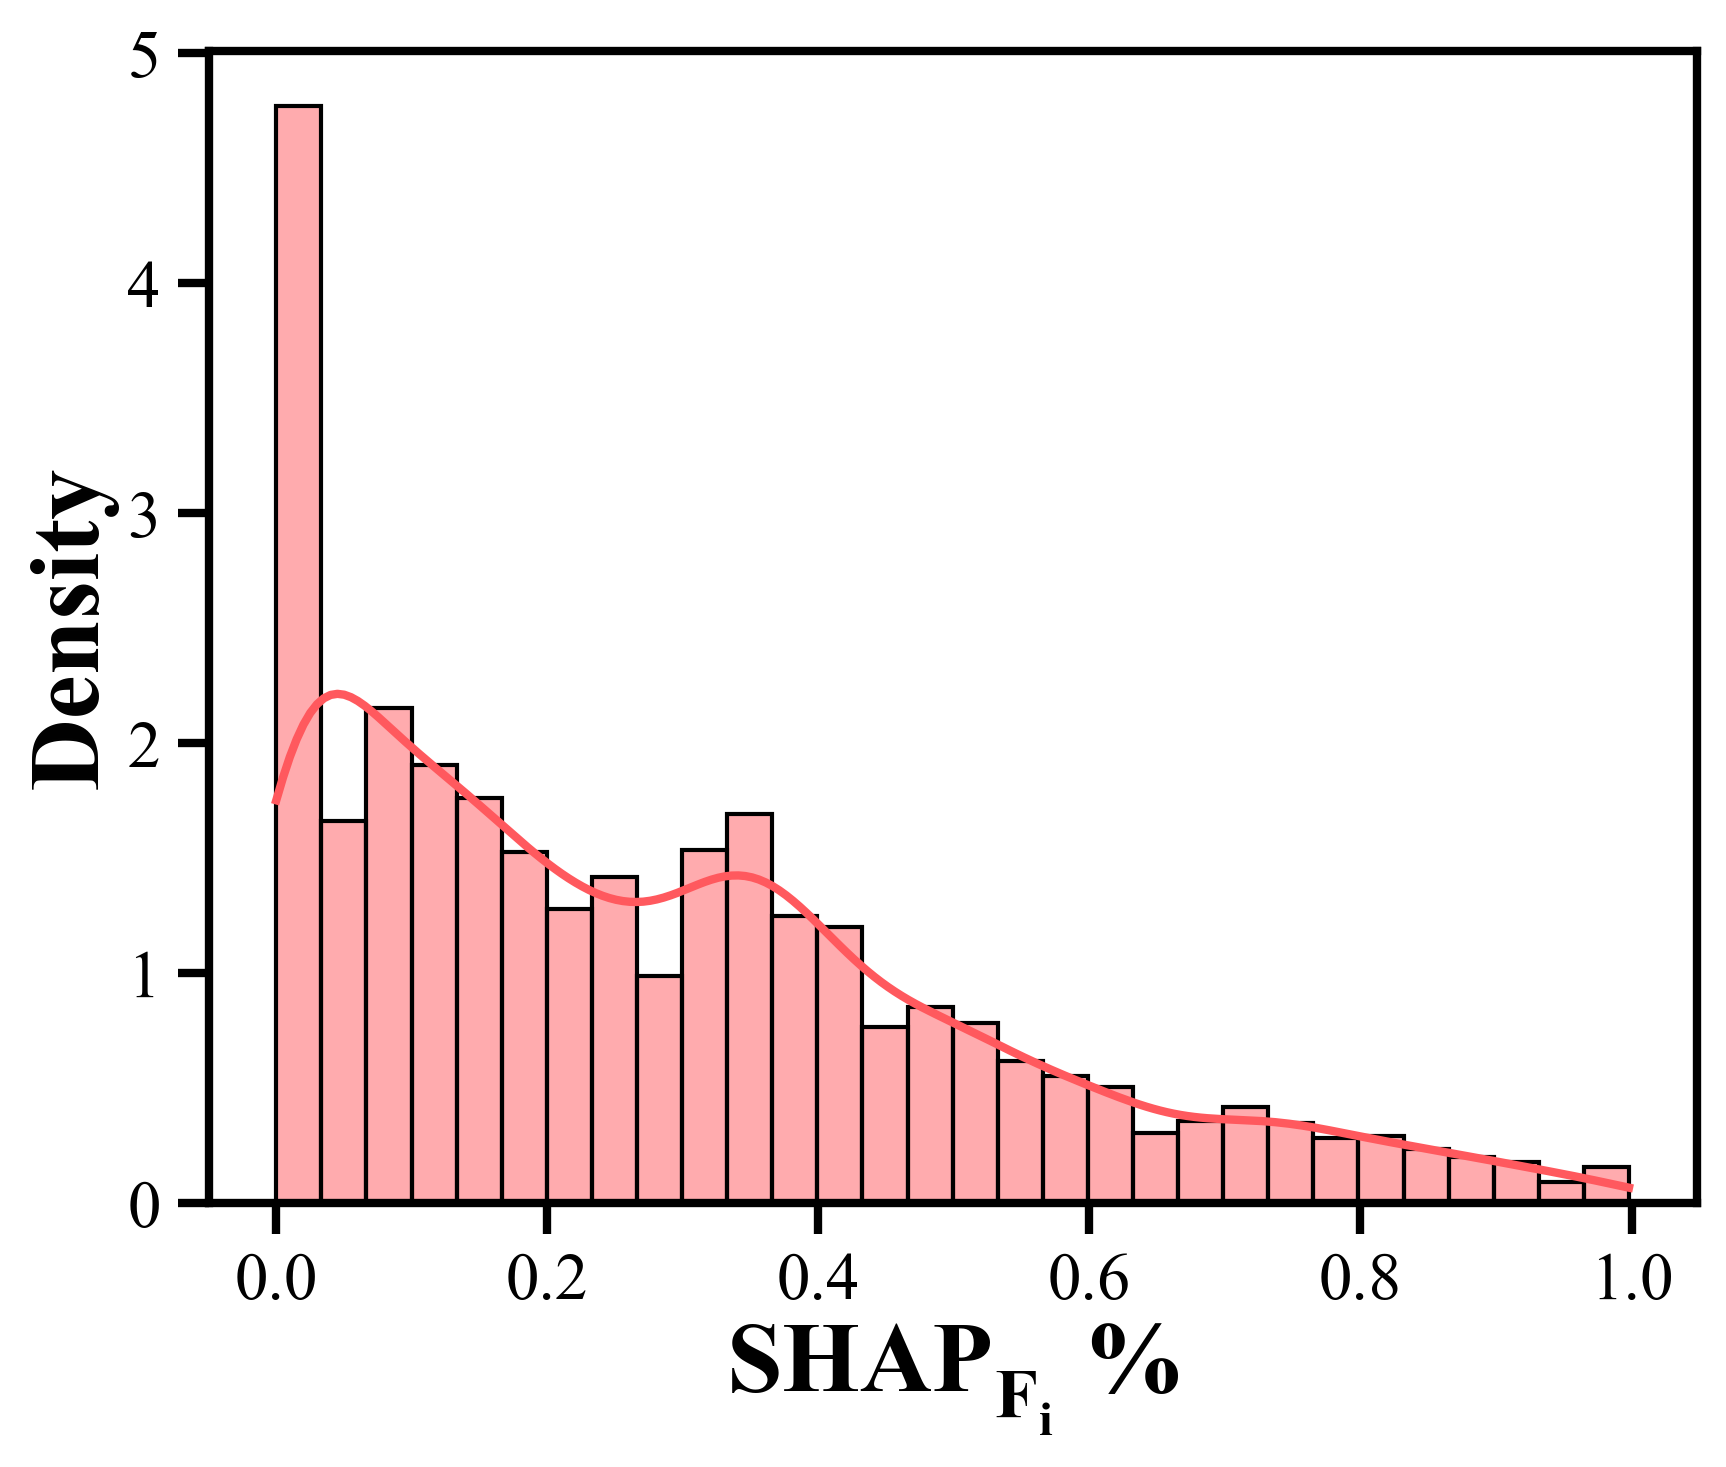

In [5]:
sns.histplot(df, x="SHAP_feat_ratio", kde=True, stat="density", bins=30)
plt.xlabel(r"$SHAP_{F_i}$ %")
plt.ylabel("Density")
plt.savefig("plots/shap_feat_ratio_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
df["perturbation_type"] = LabelEncoder().fit_transform(df["perturbation_type"])

df.drop(labels=["dataset", "feat"], axis=1, inplace=True)

df

C:\Users\11946\AppData\Local\Temp\ipykernel_10776\1636627435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["perturbation_type"] = LabelEncoder().fit_transform(df["perturbation_type"])
C:\Users\11946\AppData\Local\Temp\ipykernel_10776\1636627435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(labels=["dataset", "feat"], axis=1, inplace=True)


perturbation_type  perturbation_ratio  SHAP_feat  SHAP_feat_ratio  \
0                     2                0.05   0.031496         0.297431   
1                     2                0.05   0.027763         0.262175   
2                     2                0.05   0.036863         0.348111   
3                     2                0.05   0.026647         0.251633   
4                     2                0.05   0.009097         0.085910   
...                 ...                 ...        ...              ...   
4614                  4                0.15   0.041932         0.396910   
4616                  4                0.15   0.007102         0.067225   
4617                  4                0.15   0.018134         0.171648   
4618                  4                0.15   0.019256         0.182265   
4619                  4                0.15   0.032851         0.310950   

          max_shap_feat  DCC_pearson_matrix  Corr_pearson_matrix  \
0      Mendeleev_Number            1.000000            -0.100841   
1      Mendeleev_Number            0.928571            -0.395085   
2      Mendeleev_Number            0.928571            -0.094558   
3      Mendeleev_Number            0.928571            -0.246314   
4      Mendeleev_Number            1.000000             0.017028   
...                 ...                 ...                  ...   
4614  ZS_SS_VSA_EState8            0.523810             0.017525   
4616  ZS_SS_VSA_EState8            0.904762             0.226079   
4617  ZS_SS_VSA_EState8            0.333333            -0.229745   
4618  ZS_SS_VSA_EState8            0.714286             0.321769   
4619  ZS_SS_VSA_EState8            0.666667            -0.169058   

      DCC_spearman_matrix  Corr_spearman_matrix  DCC_kendall_matrix  ...  \
0                1.000000             -0.122882            1.000000  ...   
1                1.000000             -0.377181            1.000000  ...   
2                1.000000             -0.132373            1.000000  ...   
3                1.000000             -0.264356            1.000000  ...   
4                1.000000              0.006312            1.000000  ...   
...                   ...                   ...                 ...  ...   
4614             0.666667             -0.022470            0.904762  ...   
4616             0.952381              0.103775            0.952381  ...   
4617             0.619048             -0.177317            0.904762  ...   
4618             0.809524              0.228038            0.952381  ...   
4619             0.904762             -0.089771            0.952381  ...   

      DCC_mutual_info_matrix  Corr_mutual_info_matrix  DCC_js_corr_matrix  \
0                   1.000000                 0.024555            1.000000   
1                   0.928571                 0.077559            1.000000   
2                   1.000000                 0.091084            1.000000   
3                   1.000000                 0.025397            1.000000   
4                   1.000000                 0.012468            1.000000   
...                      ...                      ...                 ...   
4614                0.952381                 0.110179            0.952381   
4616                0.904762                 0.137900            0.809524   
4617                0.952381                 0.102717            0.904762   
4618                0.952381                 0.130991            0.904762   
4619                0.952381                 0.115994            0.857143   

      Corr_js_corr_matrix  DCC_wd_corr_matrix  Corr_wd_corr_matrix  \
0                0.313147            1.000000             0.527515   
1                0.528265            1.000000             0.568063   
2                0.320797            1.000000             0.437985   
3                0.390185            1.000000             0.420690   
4                0.547022            1.000000             0.902350   
...                   ...     

In [7]:
df.columns.to_list()

['perturbation_type',
 'perturbation_ratio',
 'SHAP_feat',
 'SHAP_feat_ratio',
 'max_shap_feat',
 'DCC_pearson_matrix',
 'Corr_pearson_matrix',
 'DCC_spearman_matrix',
 'Corr_spearman_matrix',
 'DCC_kendall_matrix',
 'Corr_kendall_matrix',
 'DCC_mutual_info_matrix',
 'Corr_mutual_info_matrix',
 'DCC_js_corr_matrix',
 'Corr_js_corr_matrix',
 'DCC_wd_corr_matrix',
 'Corr_wd_corr_matrix',
 'DCC_xi_matrix',
 'Corr_xi_matrix',
 'DCC_dcor_matrix',
 'Corr_dcor_matrix']

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, '$SHAP_{F_{i}}$'),
  Text(0, 1.5, '$SHAP_{F_{i}} \\%$'),
  Text(0, 2.5, '$\\theta$'),
  Text(0, 3.5, '$DCC(PS)_{F_{i}}$'),
  Text(0, 4.5, '$DCC(SP)_{F_{i}}$'),
  Text(0, 5.5, '$DCC(KD)_{F_{i}}$'),
  Text(0, 6.5, '$DCC(MI)_{F_{i}}$'),
  Text(0, 7.5, '$DCC(JS)_{F_{i}}$'),
  Text(0, 8.5, '$DCC(WD)_{F_{i}}$'),
  Text(0, 9.5, '$DCC(XI)_{F_{i}}$'),
  Text(0, 10.5, '$DCC(DC)_{F_{i}}$'),
  Text(0, 11.5, '$PS_{F_{i}}$'),
  Text(0, 12.5, '$SP_{F_{i}}$'),
  Text(0, 13.5, '$KD_{F_{i}}$'),
  Text(0, 14.5, '$MI_{F_{i}}$'),
  Text(0, 15.5, '$JS_{F_{i}}$'),
  Text(0, 16.5, '$WD_{F_{i}}$'),
  Text(0, 17.5, '$XI_{F_{i}}$'),
  Text(0, 18.5, '$DC_{F_{i}}$')])

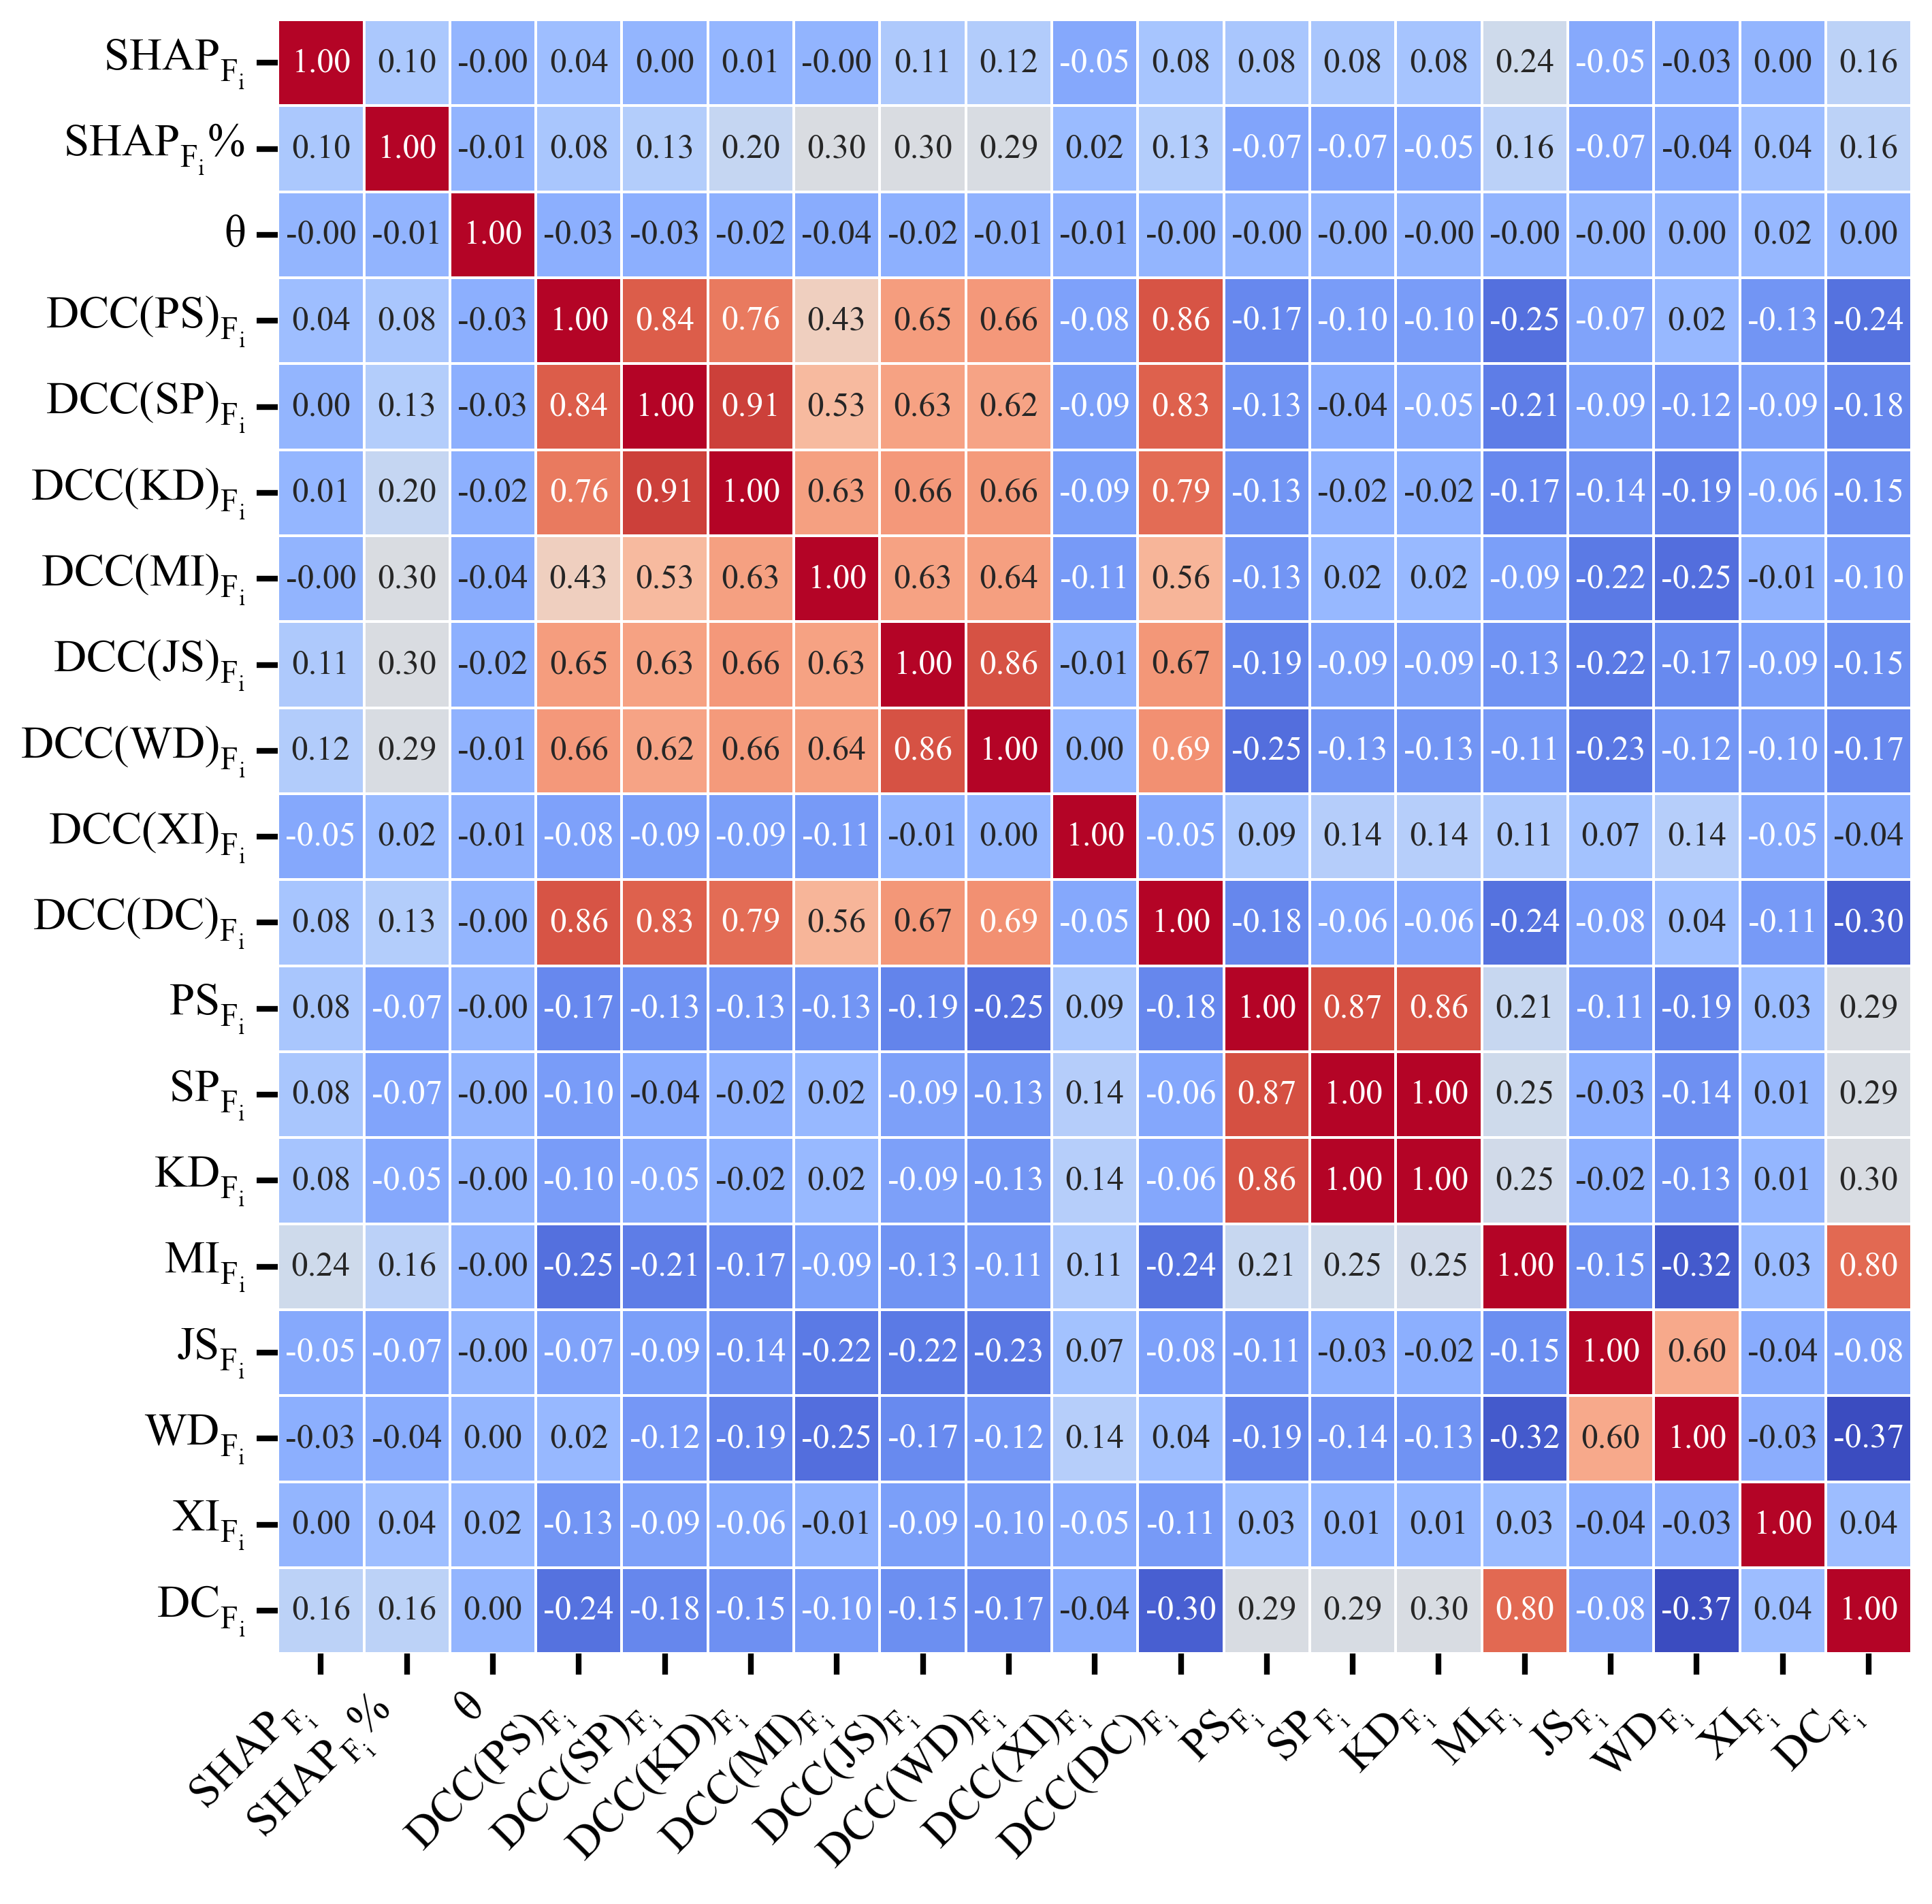

In [8]:
reorder_cols = [
    "SHAP_feat",
    "SHAP_feat_ratio",
    # "perturbation_type",
    "perturbation_ratio",
    "DCC_pearson_matrix",
    "DCC_spearman_matrix",
    "DCC_kendall_matrix",
    "DCC_mutual_info_matrix",
    "DCC_js_corr_matrix",
    "DCC_wd_corr_matrix",
    "DCC_xi_matrix",
    "DCC_dcor_matrix",
    "Corr_pearson_matrix",
    "Corr_spearman_matrix",
    "Corr_kendall_matrix",
    "Corr_mutual_info_matrix",
    "Corr_js_corr_matrix",
    "Corr_wd_corr_matrix",
    "Corr_xi_matrix",
    "Corr_dcor_matrix",
]

fig, ax = plt.subplots(figsize=(14, 10))
custom_labels = [
    r"$SHAP_{F_{i}}$",
    r"$SHAP_{F_{i}} \%$",
    # "Ptb Type",
    r"$\theta$",
    r"$DCC(PS)_{F_{i}}$",
    r"$DCC(SP)_{F_{i}}$",
    r"$DCC(KD)_{F_{i}}$",
    r"$DCC(MI)_{F_{i}}$",
    r"$DCC(JS)_{F_{i}}$",
    r"$DCC(WD)_{F_{i}}$",
    r"$DCC(XI)_{F_{i}}$",
    r"$DCC(DC)_{F_{i}}$",
    r"$PS_{F_{i}}$",
    r"$SP_{F_{i}}$",
    r"$KD_{F_{i}}$",
    r"$MI_{F_{i}}$",
    r"$JS_{F_{i}}$",
    r"$WD_{F_{i}}$",
    r"$XI_{F_{i}}$",
    r"$DC_{F_{i}}$",
]
sns.heatmap(
    df[reorder_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    xticklabels=custom_labels,
    yticklabels=custom_labels,
    cbar=False,
    square=True,    
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

In [9]:
sel_cols = [
    "SHAP_feat",
    "SHAP_feat_ratio",
    # "perturbation_type",
    "perturbation_ratio",
    "DCC_pearson_matrix",
    "DCC_spearman_matrix",
    "DCC_kendall_matrix",
    "DCC_mutual_info_matrix",
    "DCC_js_corr_matrix",
    "DCC_wd_corr_matrix",
    "DCC_xi_matrix",
    "DCC_dcor_matrix",
    "Corr_pearson_matrix",
    "Corr_spearman_matrix",
    "Corr_kendall_matrix",
    "Corr_mutual_info_matrix",
    "Corr_js_corr_matrix",
    "Corr_wd_corr_matrix",
    "Corr_xi_matrix",
    "Corr_dcor_matrix",
]

In [10]:
X_cols = [
    "Corr_pearson_matrix",
    "Corr_mutual_info_matrix",
    "Corr_js_corr_matrix",
    "Corr_dcor_matrix",
    "DCC_pearson_matrix",
    "DCC_mutual_info_matrix",
    "DCC_js_corr_matrix",
    "DCC_dcor_matrix",
]

sel_cols = [
    "SHAP_feat",
    "SHAP_feat_ratio",
] + X_cols

In [11]:
df = df[sel_cols]

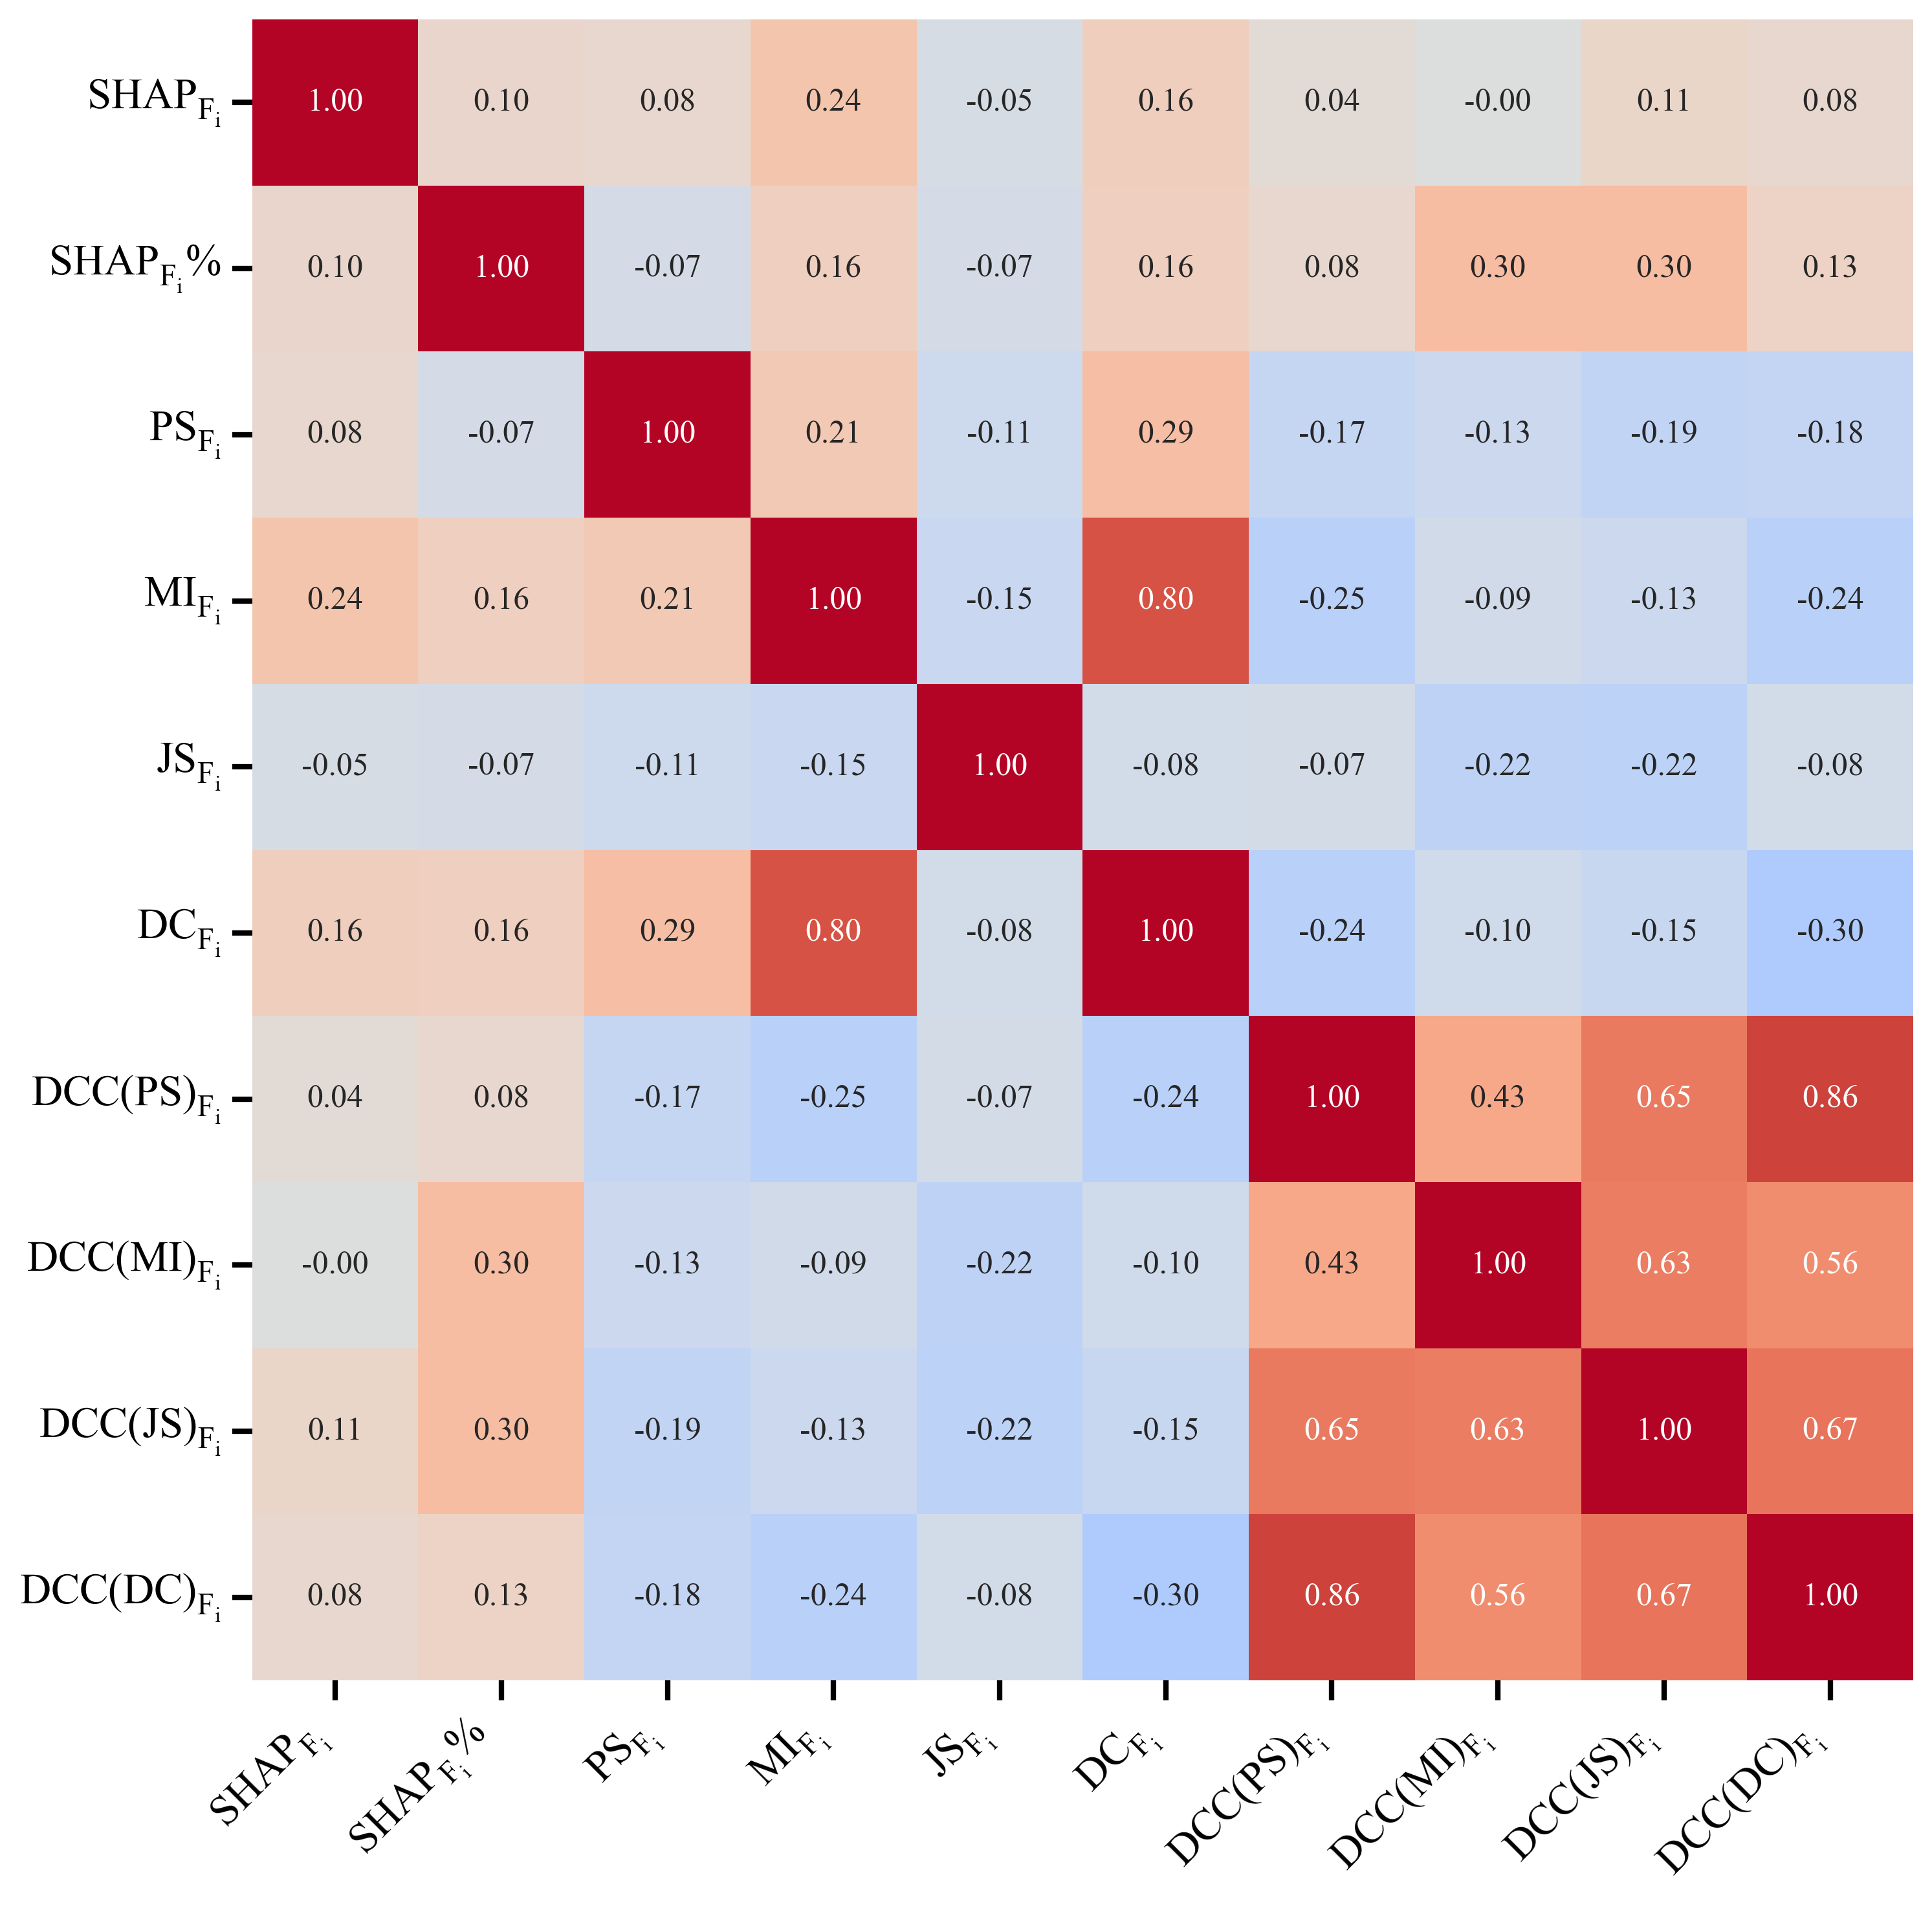

In [12]:
all_cols =["SHAP_feat", "SHAP_feat_ratio"] +  X_cols
corr = df[all_cols].corr()
plt.figure(figsize=(14, 10))
custom_labels_dict = {
    "SHAP_feat": r"$SHAP_{F_{i}}$",
    "SHAP_feat_ratio": r"$SHAP_{F_{i}} \%$",
    "DCC_pearson_matrix": r"$DCC(PS)_{F_{i}}$",
    "DCC_spearman_matrix": r"$DCC(SP)_{F_{i}}$",
    "DCC_kendall_matrix": r"$DCC(KD)_{F_{i}}$",
    "DCC_mutual_info_matrix": r"$DCC(MI)_{F_{i}}$",
    "DCC_js_corr_matrix": r"$DCC(JS)_{F_{i}}$",
    "DCC_wd_corr_matrix": r"$DCC(WD)_{F_{i}}$",
    "DCC_xi_matrix": r"$DCC(XI)_{F_{i}}$",
    "DCC_dcor_matrix": r"$DCC(DC)_{F_{i}}$",
    "Corr_pearson_matrix": r"$PS_{F_{i}}$",
    "Corr_spearman_matrix": r"$SP_{F_{i}}$",
    "Corr_kendall_matrix": r"$KD_{F_{i}}$",
    "Corr_mutual_info_matrix": r"$MI_{F_{i}}$",
    "Corr_js_corr_matrix": r"$JS_{F_{i}}$",
    "Corr_wd_corr_matrix": r"$WD_{F_{i}}$",
    "Corr_xi_matrix": r"$XI_{F_{i}}$",
    "Corr_dcor_matrix": r"$DC_{F_{i}}$",
}
custom_labels = [custom_labels_dict[col] for col in corr.columns]
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    xticklabels=custom_labels,
    yticklabels=custom_labels,
    cbar=False,
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("plots/feats_heatmap.png", dpi=300, bbox_inches="tight")

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from IPython.display import  display

def cross_validate_model(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)
    return np.mean(scores), np.std(scores)

Feature columns: ['Corr_pearson_matrix', 'Corr_mutual_info_matrix', 'Corr_js_corr_matrix', 'Corr_dcor_matrix', 'DCC_pearson_matrix', 'DCC_mutual_info_matrix', 'DCC_js_corr_matrix', 'DCC_dcor_matrix']
Used features: ['Corr_pearson_matrix', 'Corr_mutual_info_matrix', 'Corr_js_corr_matrix', 'Corr_dcor_matrix', 'DCC_pearson_matrix', 'DCC_mutual_info_matrix', 'DCC_js_corr_matrix', 'DCC_dcor_matrix']
Linear Regression: Mean Score = 0.1296, Std Dev = 0.0073
Random Forest: Mean Score = 0.9117, Std Dev = 0.0443
Gradient Boosting: Mean Score = 0.8775, Std Dev = 0.0284
AdaBoost: Mean Score = 0.8661, Std Dev = 0.0346
Extra Trees: Mean Score = 0.9658, Std Dev = 0.0062
Support Vector Regression: Mean Score = 0.0253, Std Dev = 0.0054
Ridge Regression: Mean Score = 0.1278, Std Dev = 0.0056
Lasso Regression: Mean Score = -0.0005, Std Dev = 0.0005


mean_score  std_score
Linear Regression            0.129552   0.007292
Random Forest                0.911725   0.044272
Gradient Boosting            0.877489   0.028401
AdaBoost                     0.866121   0.034600
Extra Trees                  0.965803   0.006205
Support Vector Regression    0.025278   0.005425
Ridge Regression             0.127793   0.005574
Lasso Regression            -0.000489   0.000481

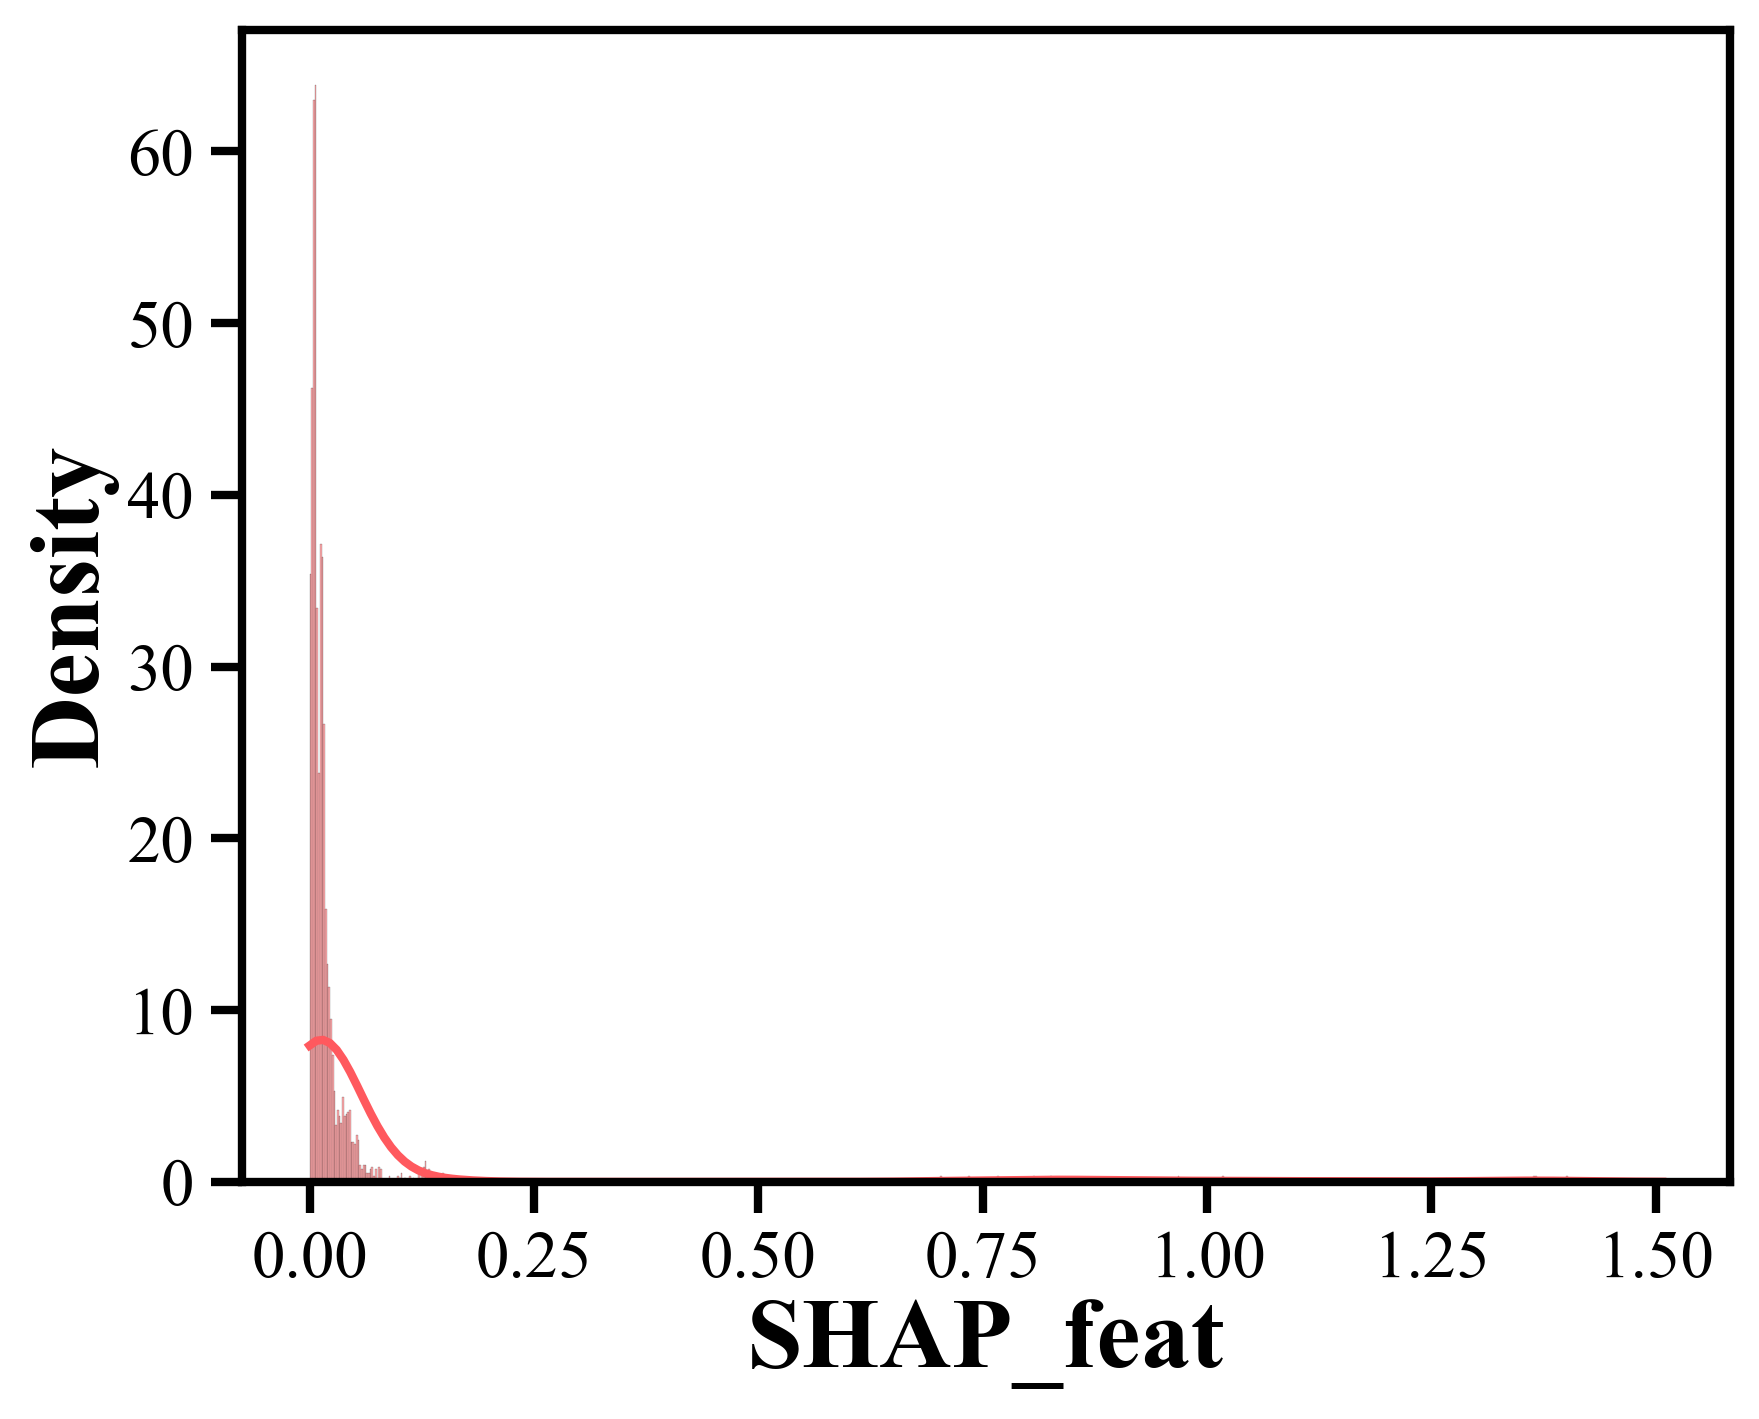

In [14]:
X = df.drop(columns=["SHAP_feat", "SHAP_feat_ratio"])
print("Feature columns:", X.columns.tolist())
y = df["SHAP_feat"]
y = np.log10(y + 1 + eps)
sns.histplot(y, kde=True, stat="density")
print("Used features:", X.columns.tolist())

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR(kernel='linear'),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

results = defaultdict(dict)
for model_name, model in models.items():
    mean_score, std_score = cross_validate_model(model, X, y)
    results[model_name]["mean_score"] = mean_score
    results[model_name]["std_score"] = std_score
    print(f"{model_name}: Mean Score = {mean_score:.4f}, Std Dev = {std_score:.4f}")

df_results = pd.DataFrame(results).T
df_results

Box-Cox Lambda: -0.012064615760812778


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


R2 Scores: [0.9205181913774104, 0.8382396657150541, 0.9255902804112756, 0.8394308643412784, 0.85217463675196]
Adjusted R2 Scores: [0.919759415161443, 0.8366954143137659, 0.9248799250930061, 0.8378979847645842, 0.8507634161004274]


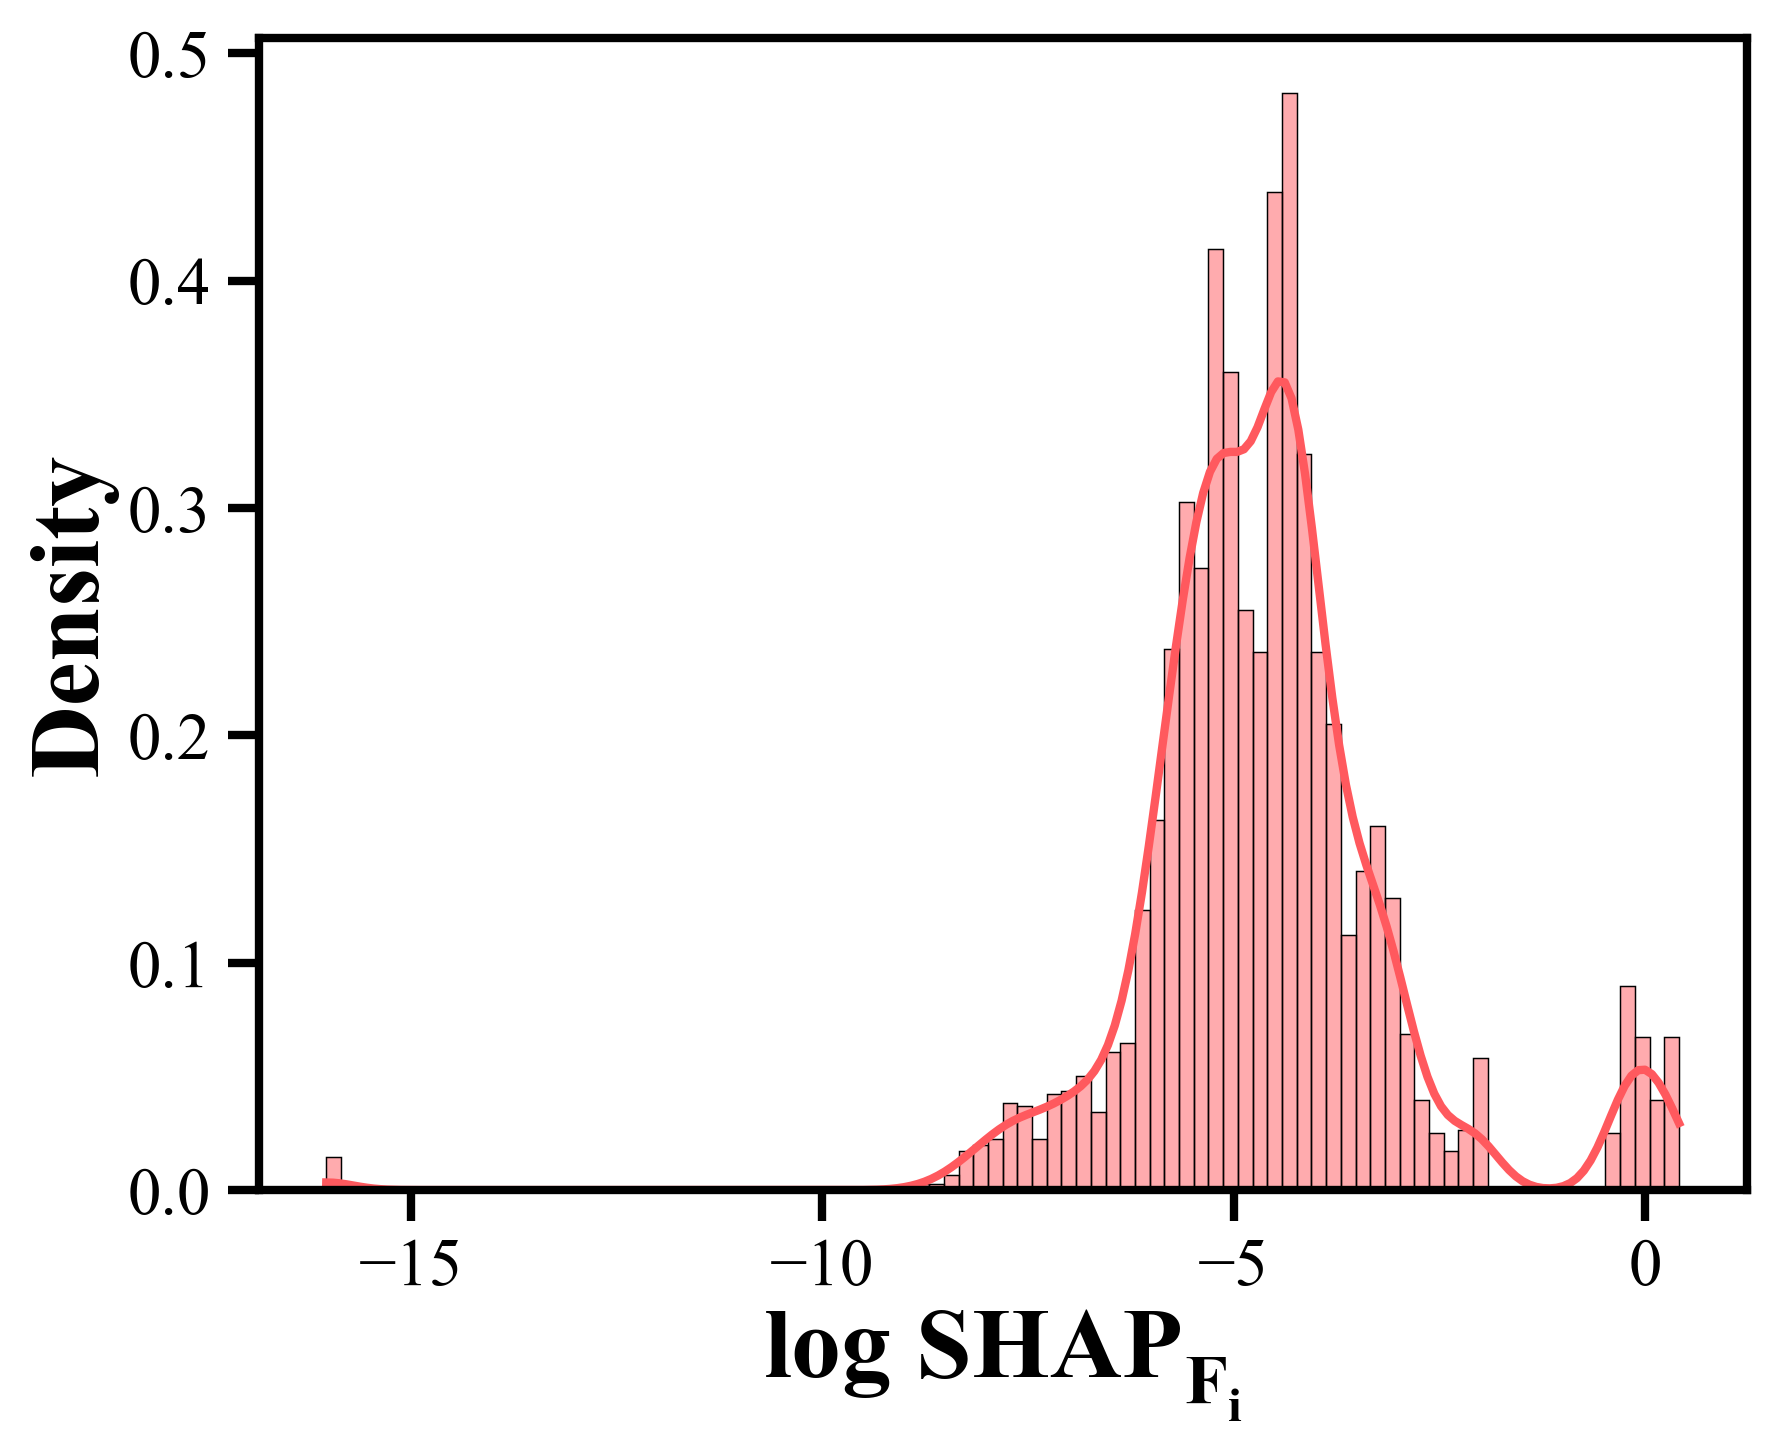

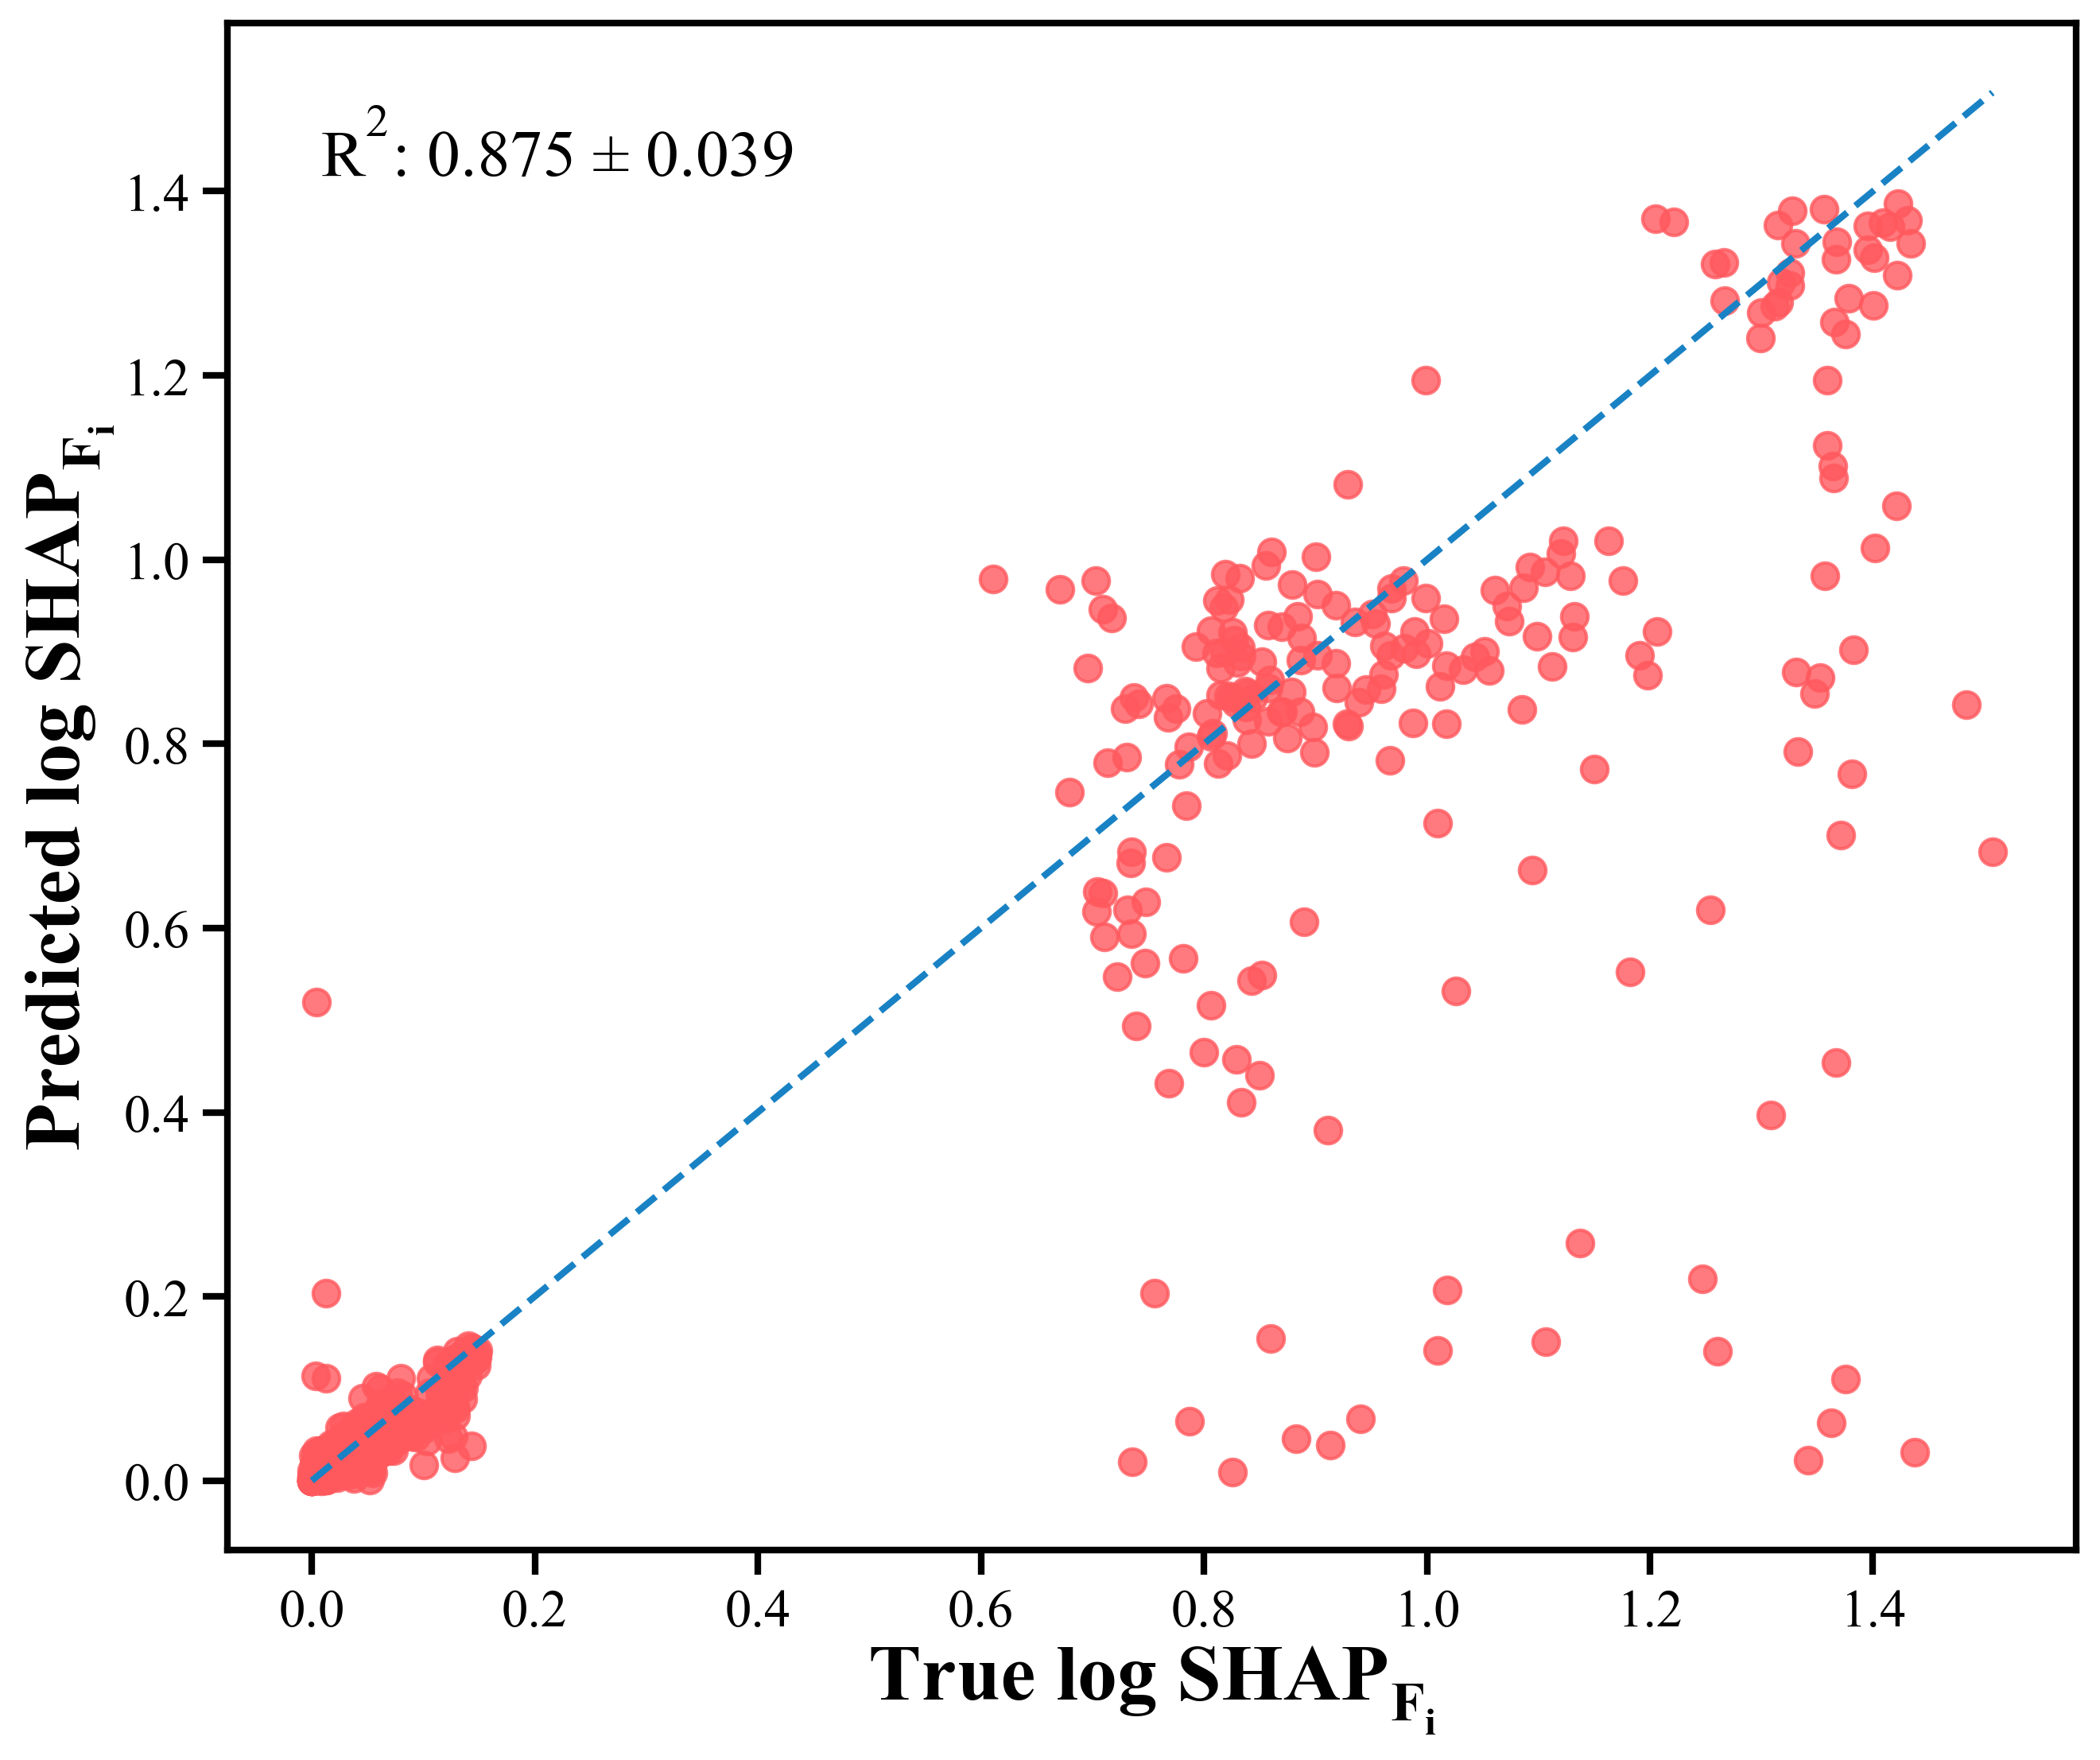

In [15]:
def run_fold(train_index, test_index, X, y, model, lambda_=None):
    """
    单折训练 + 验证 + SHAP 计算
    """
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds = np.array(preds)
    y_test = np.array(y_test)

    if boxcox_transform:
        preds = inv_boxcox(preds, lambda_)
        y_test = inv_boxcox(y_test, lambda_)

    r2 = r2_score(y_test, preds)
    adjusted_r2 = adjusted_r2_score(y_test, preds, X_test.shape[1])

    # shap
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    return {
        "y_true": y_test.tolist(),
        "y_pred": preds.tolist(),
        "r2": r2,
        "adjusted_r2": adjusted_r2,
        "shap_values": shap_values,
        "X_test": X_test
    }

# ================== 并行运行 ==================
best_model = RandomForestRegressor(n_estimators=500, random_state=42)
lambda_ = None
if boxcox_transform:
    y_vals, lambda_ = boxcox(y)
    print("Box-Cox Lambda:", lambda_)
    sns.histplot(y_vals, kde=True, stat="density")
    plt.xlabel(r"log $SHAP_{F_i}$")
    plt.ylabel("Density")

y = pd.Series(y_vals, index=y.index)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_fold)(train_idx, test_idx, X, y, best_model, lambda_)
    for train_idx, test_idx in kf.split(X)
)

# for train_idx, test_idx in kf.split(X):
#     res = run_fold(train_idx, test_idx, X, y, best_model, lambda_)
#     results.append(res)

# ================== 汇总结果 ==================
all_trues = []
all_preds = []
r2_scores = []
adjusted_r2_scores = []
shap_values_all = []
X_all = []

for res in results:    
    all_trues.extend(res["y_true"])
    all_preds.extend(res["y_pred"])
    r2_scores.append(res["r2"])
    adjusted_r2_scores.append(res["adjusted_r2"])
    shap_values_all.append(res["shap_values"])
    X_all.append(res["X_test"])

print(f"R2 Scores: {r2_scores}")
print(f"Adjusted R2 Scores: {adjusted_r2_scores}")
# ================== 绘图 ==================
plt.figure(figsize=(10, 8))
plt.plot([min(all_trues), max(all_trues)], [min(all_trues), max(all_trues)], color='#1982C4', linestyle='--')
plt.scatter(all_trues, all_preds, alpha=0.8)
# add a diagonal line
plt.xlabel(r"True log $SHAP_{F_{i}}$")
plt.ylabel(r"Predicted log $SHAP_{F_{i}}$")

plt.text(0.05, 0.90, f"$R^2$: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}", transform=plt.gca().transAxes, fontsize=20)
# plt.text(0.05, 0.85, r"$R^2_{adjsuted}$"+ f": {np.mean(adjusted_r2_scores):.3f} ± {np.std(adjusted_r2_scores):.3f}", transform=plt.gca().transAxes, fontsize=20)
plt.savefig("plots/shap_fi_r2_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import pickle

best_model.fit(X, y)
# 保存模型
with open("models/rf_model_shap.pkl", "wb") as f:
    pickle.dump(best_model, f)

Default feature order: ['Corr_mutual_info_matrix', 'Corr_dcor_matrix', 'Corr_js_corr_matrix', 'DCC_js_corr_matrix', 'Corr_pearson_matrix', 'DCC_mutual_info_matrix', 'DCC_pearson_matrix', 'DCC_dcor_matrix']
Custom feature names: ['$DCC(DC)_{F_{i}}$', '$DCC(PS)_{F_{i}}$', '$DCC(MI)_{F_{i}}$', '$PS_{F_{i}}$', '$DCC(JS)_{F_{i}}$', '$JS_{F_{i}}$', '$DC_{F_{i}}$', '$MI_{F_{i}}$']


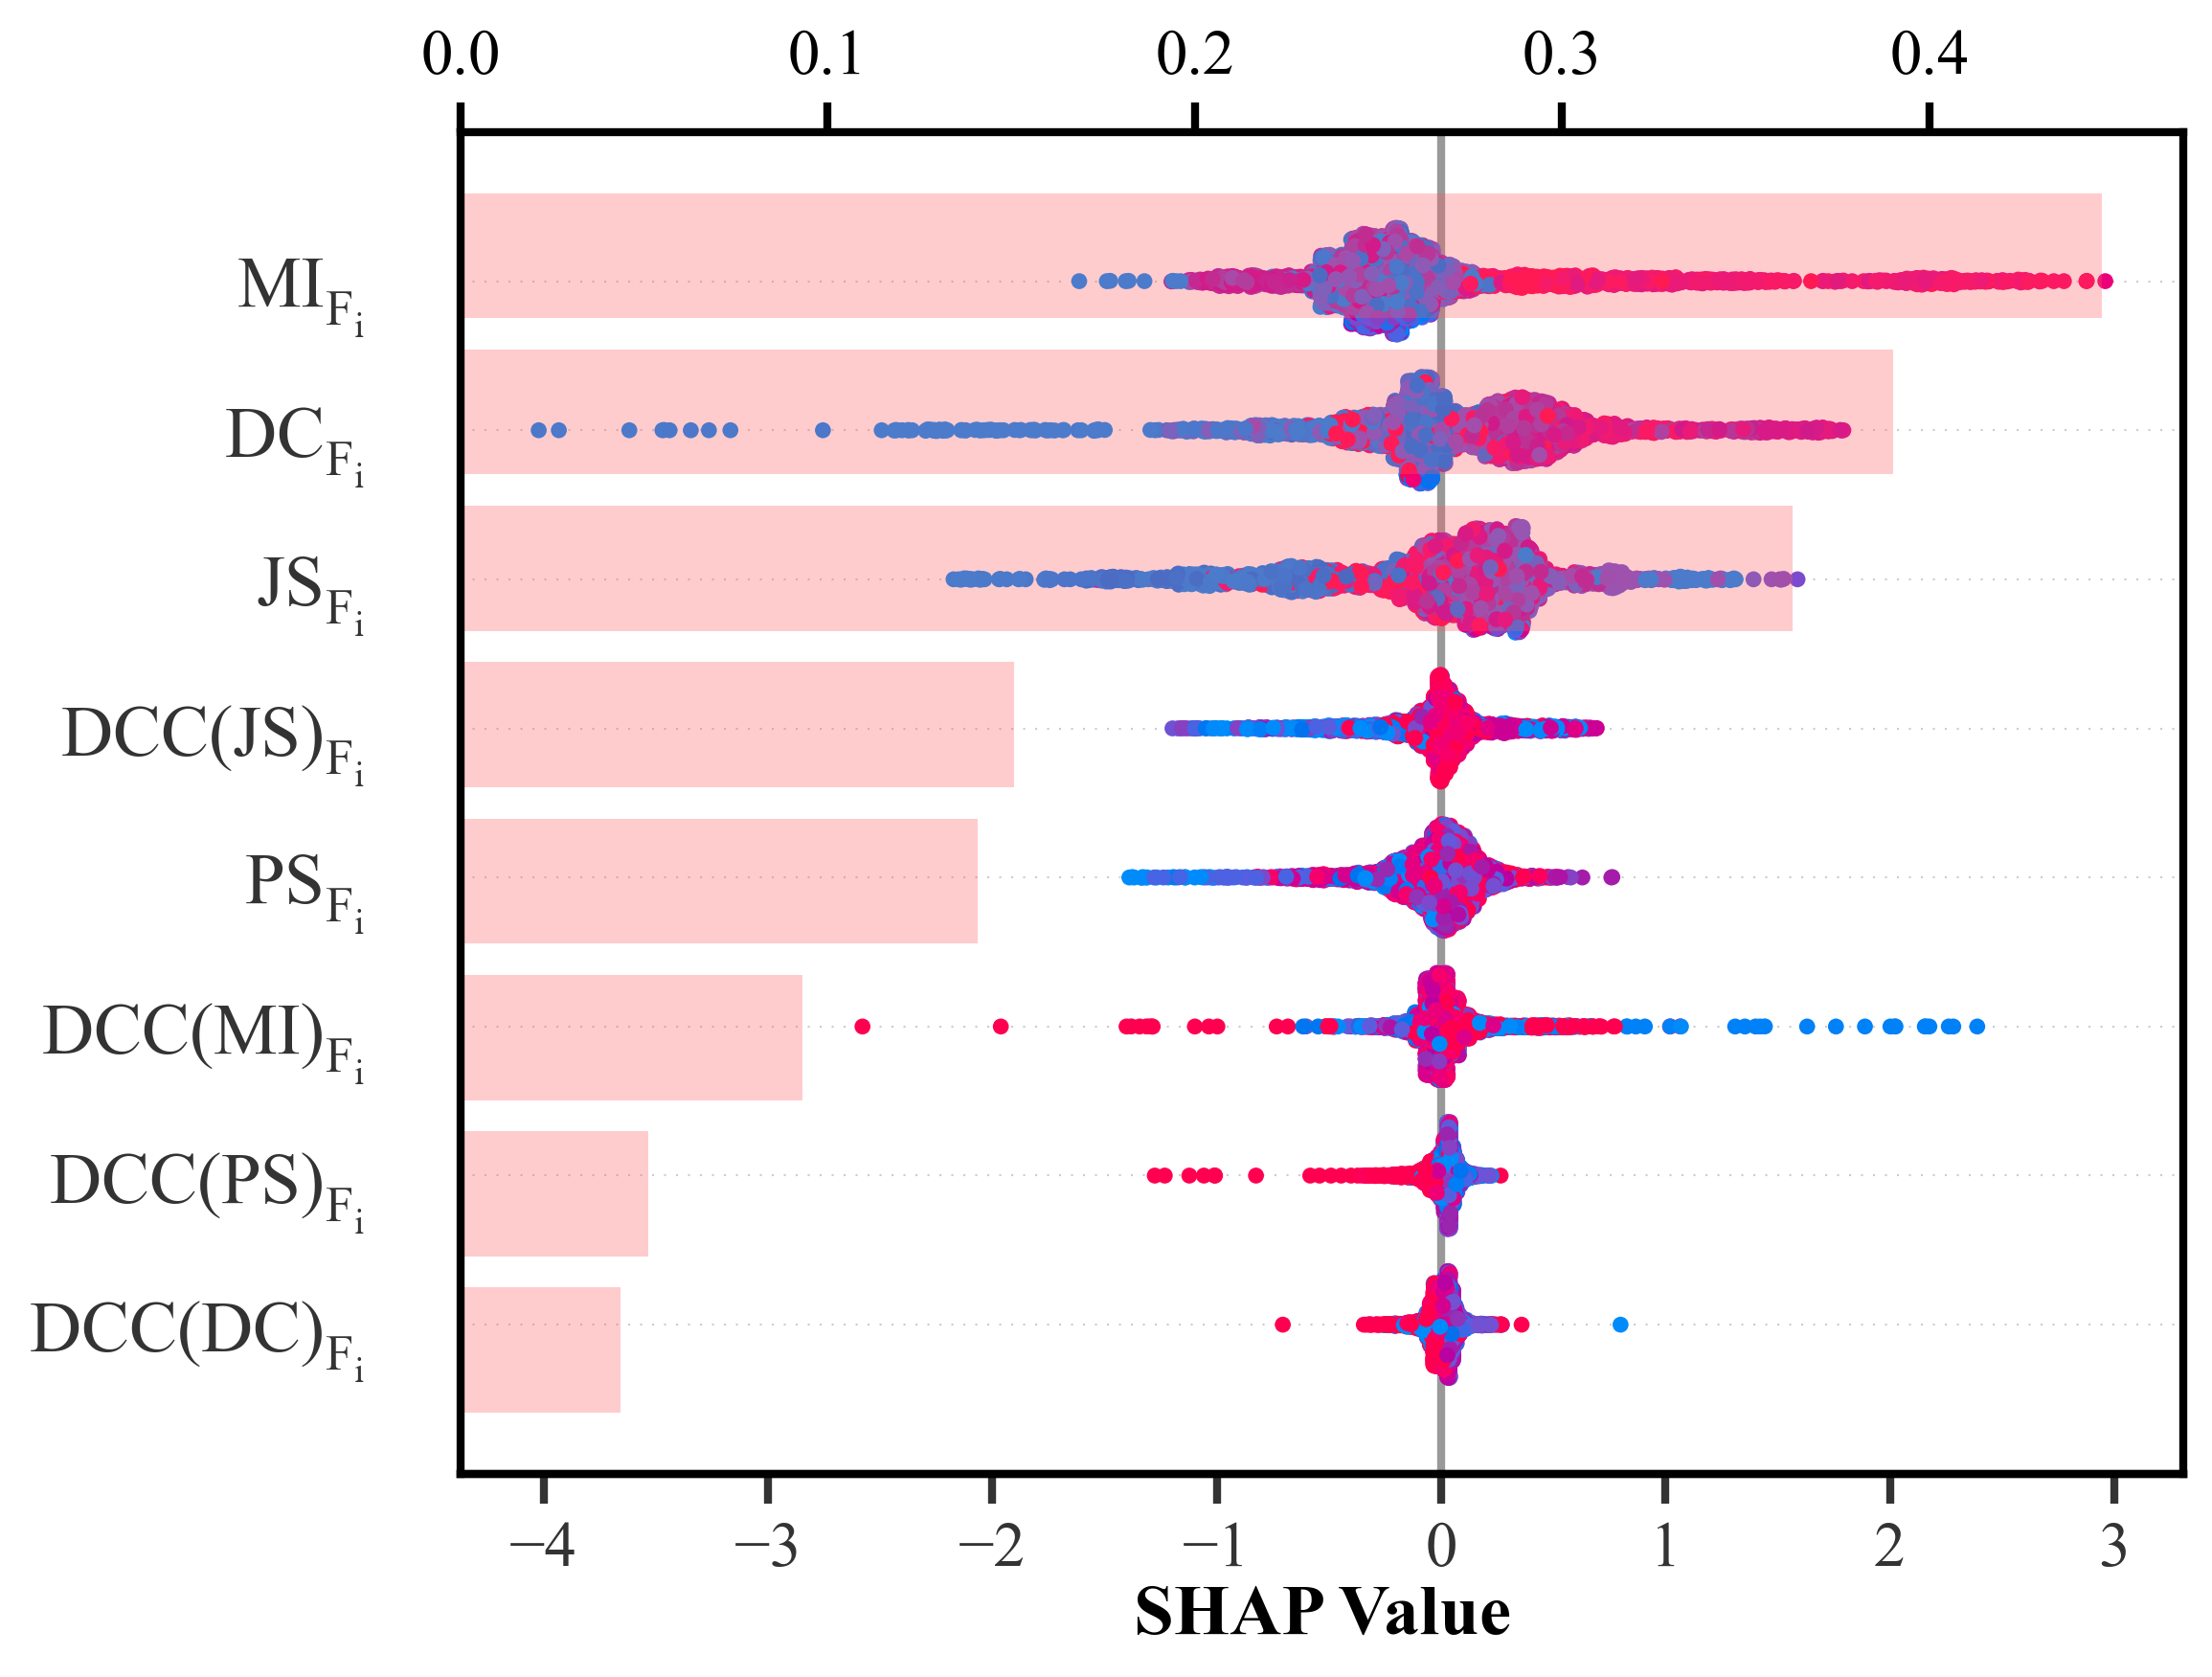

In [17]:
# ========== SHAP 合并画图 ==========
# 合并所有折的 SHAP 值和输入
shap_values_concat = np.concatenate(shap_values_all, axis=0)
X_concat = pd.concat(X_all, axis=0)

fig, ax1 = plt.subplots(figsize=(8, 6))

max_display = len(X_cols)

# ===== 绘制 SHAP 点图 =====
shap.summary_plot(
    shap_values_concat, 
    X_concat, 
    show=False, 
    color_bar=False,
    max_display=max_display,
)

# 计算默认特征重要性顺序（用于排序）
mean_abs_shap = np.abs(shap_values_concat).mean(axis=0)
sort_idx = np.argsort(mean_abs_shap)[::-1]
feature_names = X_concat.columns[sort_idx].tolist()
print("Default feature order:", feature_names)

# 替换为自定义名称
custom_names_dict = {
    "SHAP_feat": r"$SHAP_{F_{i}}$",
    "SHAP_feat_ratio": r"$SHAP_{F_{i}} \%$",
    "perturbation_type": r"$\theta$",
    "perturbation_ratio": r"$\theta$",
    "DCC_pearson_matrix": r"$DCC(PS)_{F_{i}}$",
    "DCC_spearman_matrix": r"$DCC(SP)_{F_{i}}$",
    "DCC_kendall_matrix": r"$DCC(KD)_{F_{i}}$",
    "DCC_mutual_info_matrix": r"$DCC(MI)_{F_{i}}$",
    "DCC_js_corr_matrix": r"$DCC(JS)_{F_{i}}$",
    "DCC_wd_corr_matrix": r"$DCC(WD)_{F_{i}}$",
    "DCC_xi_matrix": r"$DCC(XI)_{F_{i}}$",
    "DCC_dcor_matrix": r"$DCC(DC)_{F_{i}}$",
    "Corr_pearson_matrix": r"$PS_{F_{i}}$",
    "Corr_spearman_matrix": r"$SP_{F_{i}}$",
    "Corr_kendall_matrix": r"$KD_{F_{i}}$",
    "Corr_mutual_info_matrix": r"$MI_{F_{i}}$",
    "Corr_js_corr_matrix": r"$JS_{F_{i}}$",
    "Corr_wd_corr_matrix": r"$WD_{F_{i}}$",
    "Corr_xi_matrix": r"$XI_{F_{i}}$",
    "Corr_dcor_matrix": r"$DC_{F_{i}}$",
}
custom_names = [custom_names_dict[col] for col in feature_names[:max_display]]
custom_names = list(reversed(custom_names))
print("Custom feature names:", custom_names)


plt.gca().tick_params(axis='x', labelsize=16)
plt.gca().set_xlabel("SHAP Value", fontsize=18)
plt.gca().set_yticklabels(custom_names, fontsize=18)

# ===== 绘制 SHAP 条形图 =====
ax2 = ax1.twiny()
bar_heights = mean_abs_shap[sort_idx][::-1]
ax2.barh(
    np.arange(max_display),
    bar_heights[:max_display],
    alpha=0.3,
)

# 调整布局
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig("plots/shap_fi_summary.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
X = df.drop(columns=["SHAP_feat", "SHAP_feat_ratio"])
y= df["SHAP_feat_ratio"] + eps
print("Used features:", X.columns.tolist())
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR(kernel='linear'),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

results = defaultdict(dict)
for model_name, model in models.items():
    mean_score, std_score = cross_validate_model(model, X, y)
    results[model_name]["mean_score"] = mean_score
    results[model_name]["std_score"] = std_score
    print(f"{model_name}: Mean Score = {mean_score:.4f}, Std Dev = {std_score:.4f}")

df_results = pd.DataFrame(results).T
df_results

Used features: ['Corr_pearson_matrix', 'Corr_mutual_info_matrix', 'Corr_js_corr_matrix', 'Corr_dcor_matrix', 'DCC_pearson_matrix', 'DCC_mutual_info_matrix', 'DCC_js_corr_matrix', 'DCC_dcor_matrix']
Linear Regression: Mean Score = 0.1728, Std Dev = 0.0127
Random Forest: Mean Score = 0.8622, Std Dev = 0.0139
Gradient Boosting: Mean Score = 0.6933, Std Dev = 0.0292
AdaBoost: Mean Score = 0.3097, Std Dev = 0.0539
Extra Trees: Mean Score = 0.8676, Std Dev = 0.0152
Support Vector Regression: Mean Score = 0.1537, Std Dev = 0.0198
Ridge Regression: Mean Score = 0.1728, Std Dev = 0.0125
Lasso Regression: Mean Score = -0.0004, Std Dev = 0.0005


mean_score  std_score
Linear Regression            0.172807   0.012663
Random Forest                0.862241   0.013905
Gradient Boosting            0.693275   0.029166
AdaBoost                     0.309691   0.053884
Extra Trees                  0.867558   0.015225
Support Vector Regression    0.153689   0.019772
Ridge Regression             0.172835   0.012463
Lasso Regression            -0.000438   0.000474

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


R2 Scores: [0.8460524712498958, 0.8733181780931906, 0.8543371457168667, 0.8321202756025313, 0.8651883864349517]
Adjusted R2 Scores: [0.84458280510431, 0.8721088050916936, 0.8529465695423261, 0.8305176052025555, 0.8639014020572424]


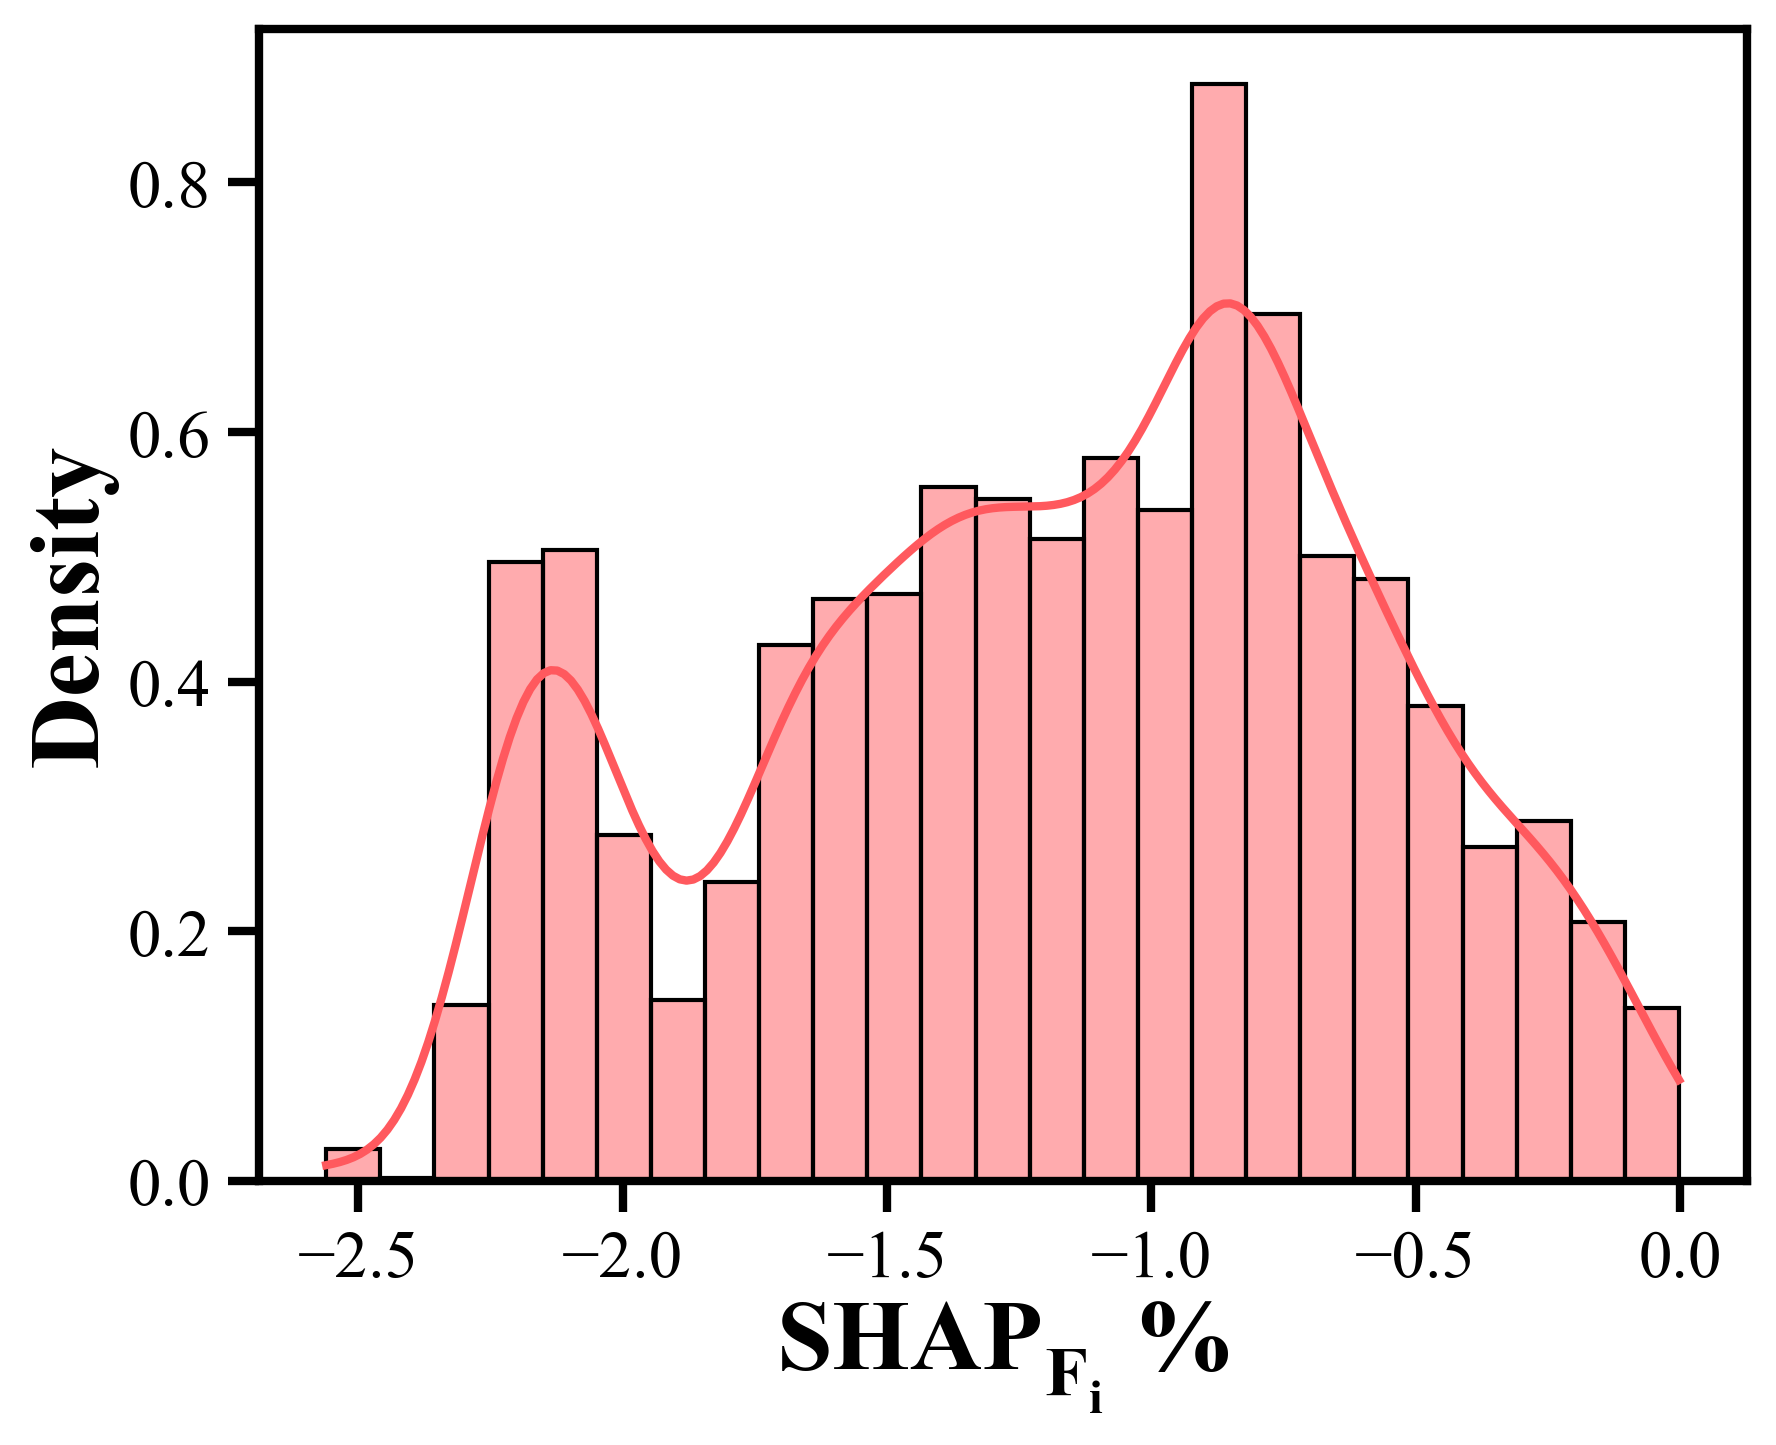

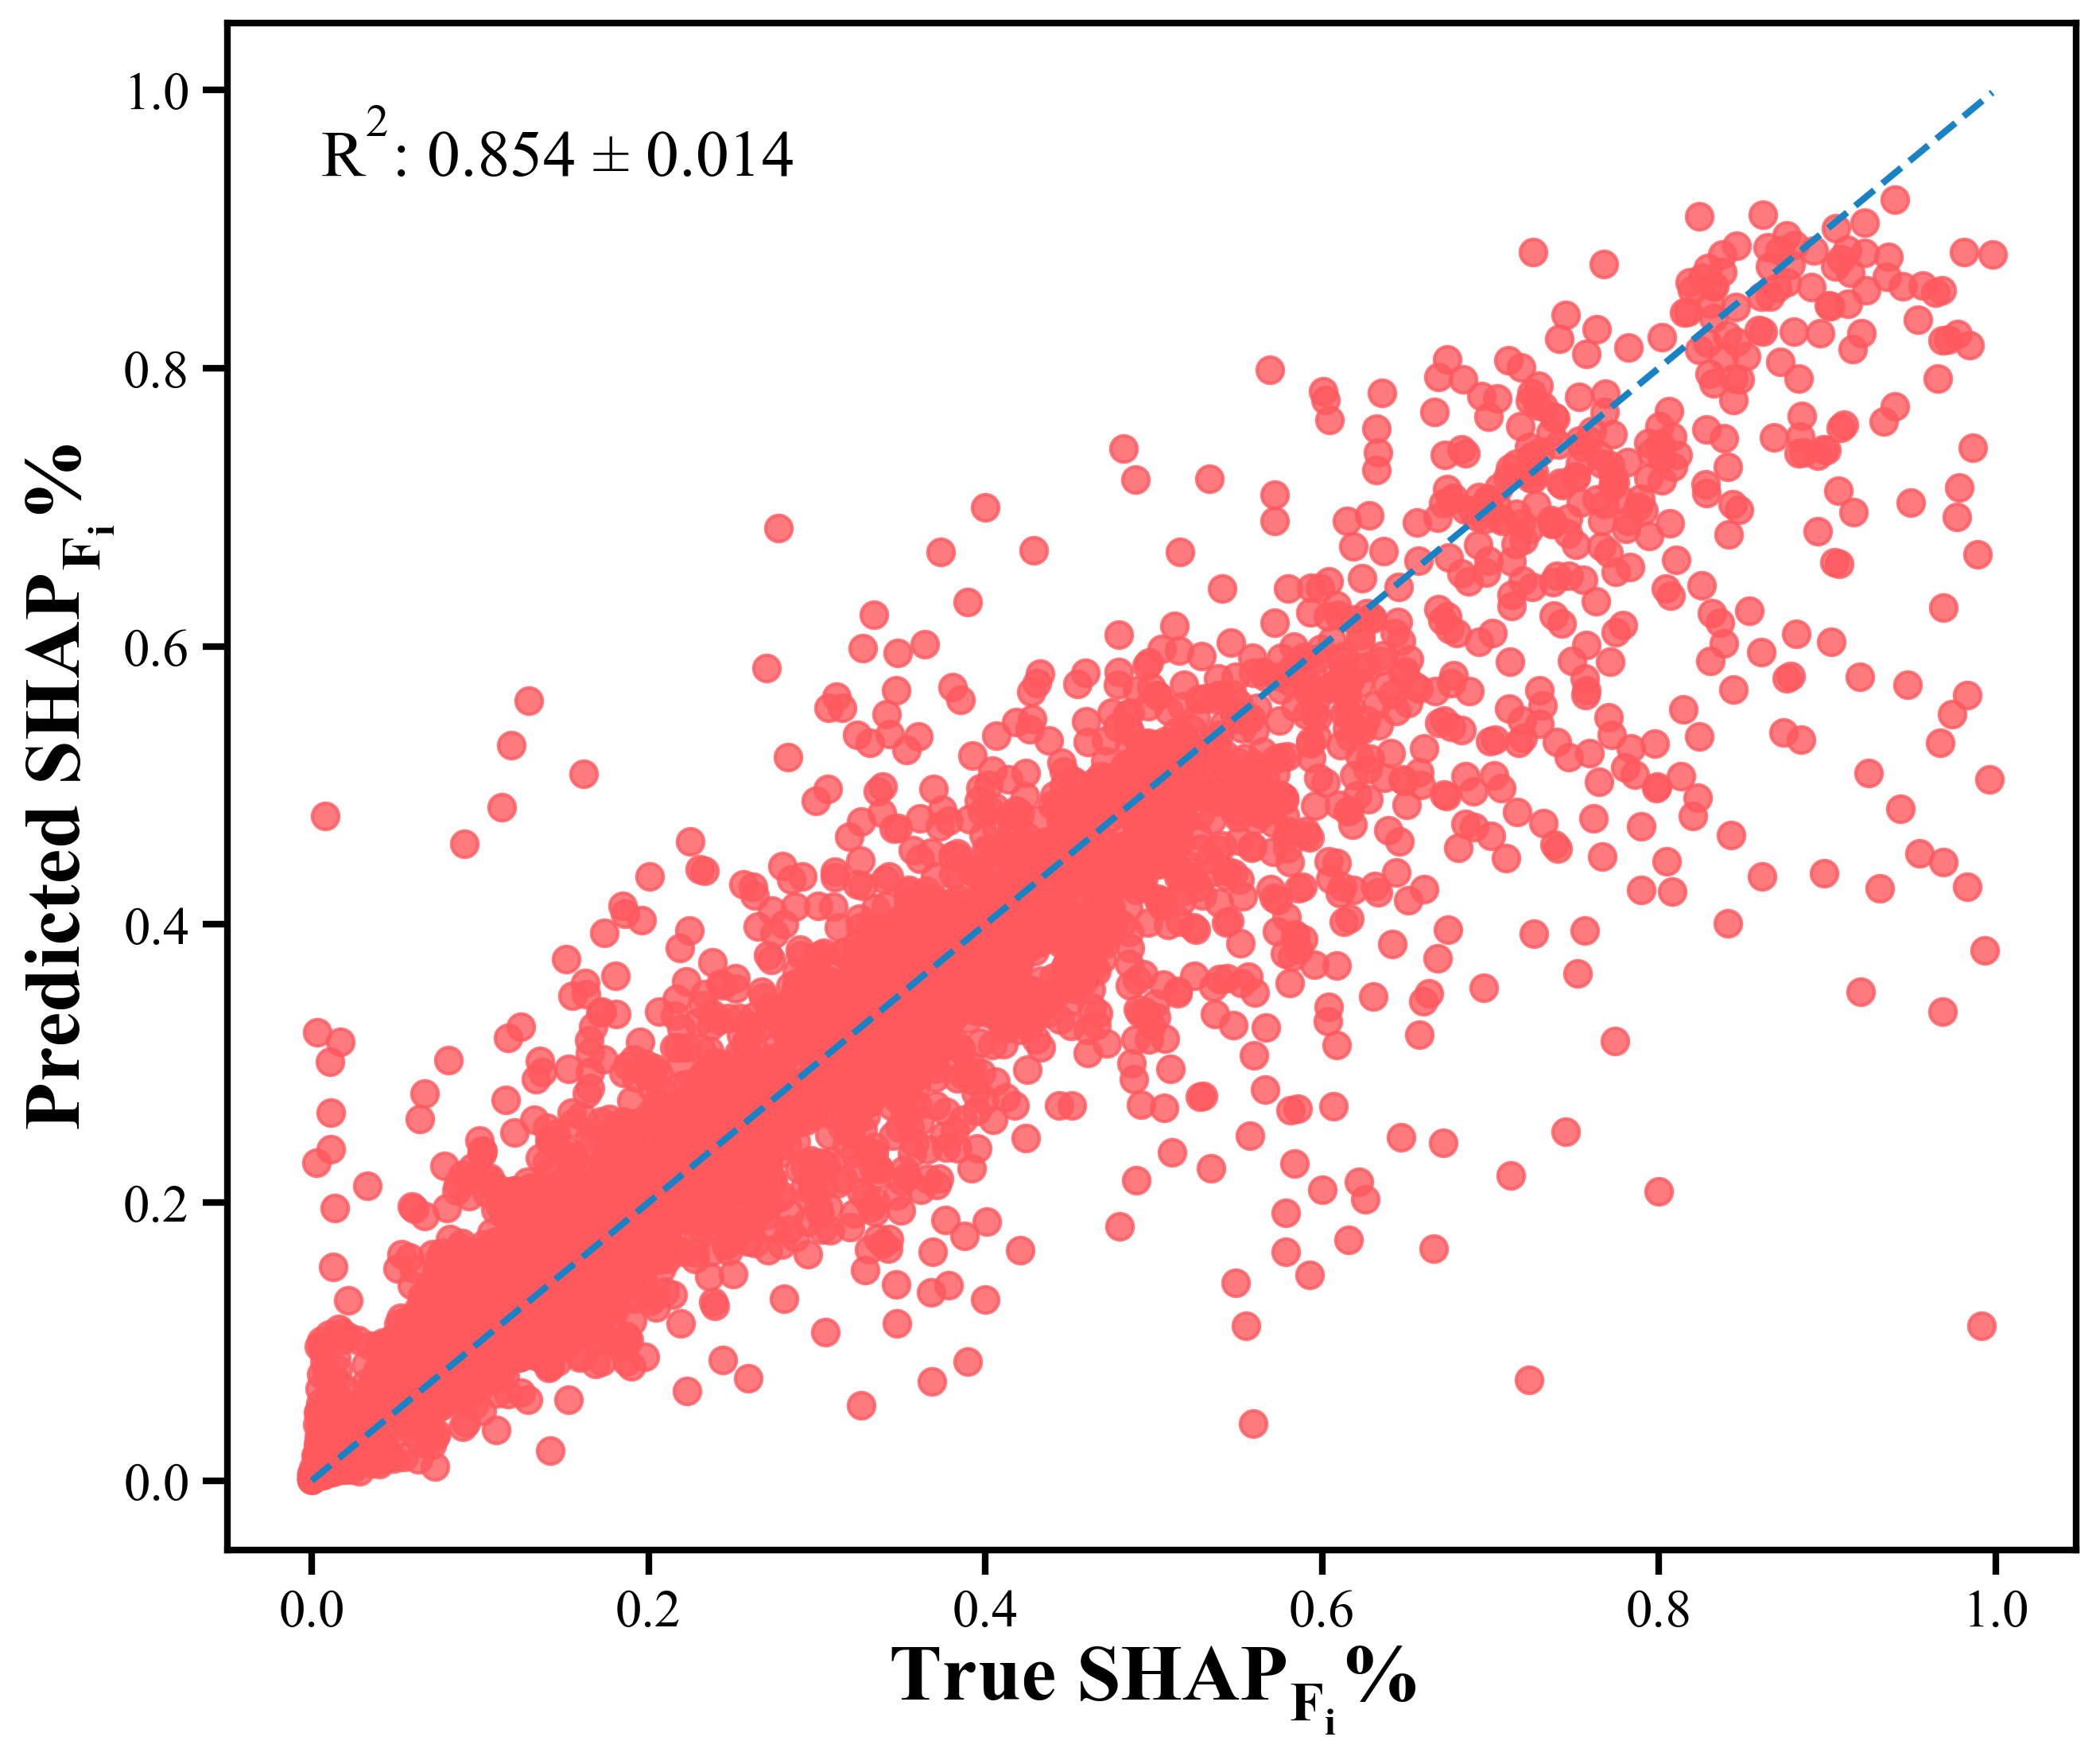

In [19]:
def run_fold(train_index, test_index, X, y, model, lambda_=None):
    """
    单折训练 + 验证 + SHAP 计算
    """
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    if boxcox_transform:
        preds = inv_boxcox(preds, lambda_)
        y_test = inv_boxcox(y_test, lambda_)

    r2 = r2_score(y_test, preds)
    adjusted_r2 = adjusted_r2_score(y_test, preds, X_test.shape[1])

    # shap
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    return {
        "y_true": y_test.tolist(),
        "y_pred": preds.tolist(),
        "r2": r2,
        "adjusted_r2": adjusted_r2,
        "shap_values": shap_values,
        "X_test": X_test
    }

# ================== 并行运行 ==================
best_model = RandomForestRegressor(n_estimators=500, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
lambda_ = None
if boxcox_transform:
    y_vals, lambda_ = boxcox(y)
    sns.histplot(y_vals, kde=True, stat="density")
    plt.xlabel(r"$SHAP_{F_i}$ %")
    plt.ylabel("Density")

y = pd.Series(y_vals, index=y.index)
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_fold)(train_idx, test_idx, X, y, best_model, lambda_)
    for train_idx, test_idx in kf.split(X)
)

# ================== 汇总结果 ==================
all_trues = []
all_preds = []
r2_scores = []
adjusted_r2_scores = []
shap_values_all = []
X_all = []

for res in results:
    all_trues.extend(res["y_true"])
    all_preds.extend(res["y_pred"])
    r2_scores.append(res["r2"])
    adjusted_r2_scores.append(res["adjusted_r2"])
    shap_values_all.append(res["shap_values"])
    X_all.append(res["X_test"])

print(f"R2 Scores: {r2_scores}")
print(f"Adjusted R2 Scores: {adjusted_r2_scores}")

# ================== 绘图 ==================
plt.figure(figsize=(10, 8))
plt.plot([min(all_trues), max(all_trues)], [min(all_trues), max(all_trues)], 
         color='#1982C4', linestyle='--')
plt.scatter(all_trues, all_preds, alpha=0.8)

plt.xlabel(r"True $SHAP_{F_{i}}$%")
plt.ylabel(r"Predicted $SHAP_{F_{i}}$%")
plt.text(0.05, 0.90, 
         f"$R^2$: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}", 
         transform=plt.gca().transAxes, fontsize=20)
# plt.text(0.05, 0.85, r"$R^2_{adjsuted}$"+ f": {np.mean(adjusted_r2_scores):.3f} ± {np.std(adjusted_r2_scores):.3f}", transform=plt.gca().transAxes, fontsize=20)
plt.savefig("plots/shap_fi_ratio_r2_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

Default feature order: ['Corr_js_corr_matrix', 'DCC_js_corr_matrix', 'Corr_mutual_info_matrix', 'Corr_dcor_matrix', 'DCC_mutual_info_matrix', 'Corr_pearson_matrix', 'DCC_pearson_matrix', 'DCC_dcor_matrix']
Custom feature names: ['$DCC(DC)_{F_{i}}$', '$DCC(PS)_{F_{i}}$', '$PS_{F_{i}}$', '$DCC(MI)_{F_{i}}$', '$DC_{F_{i}}$', '$MI_{F_{i}}$', '$DCC(JS)_{F_{i}}$', '$JS_{F_{i}}$']


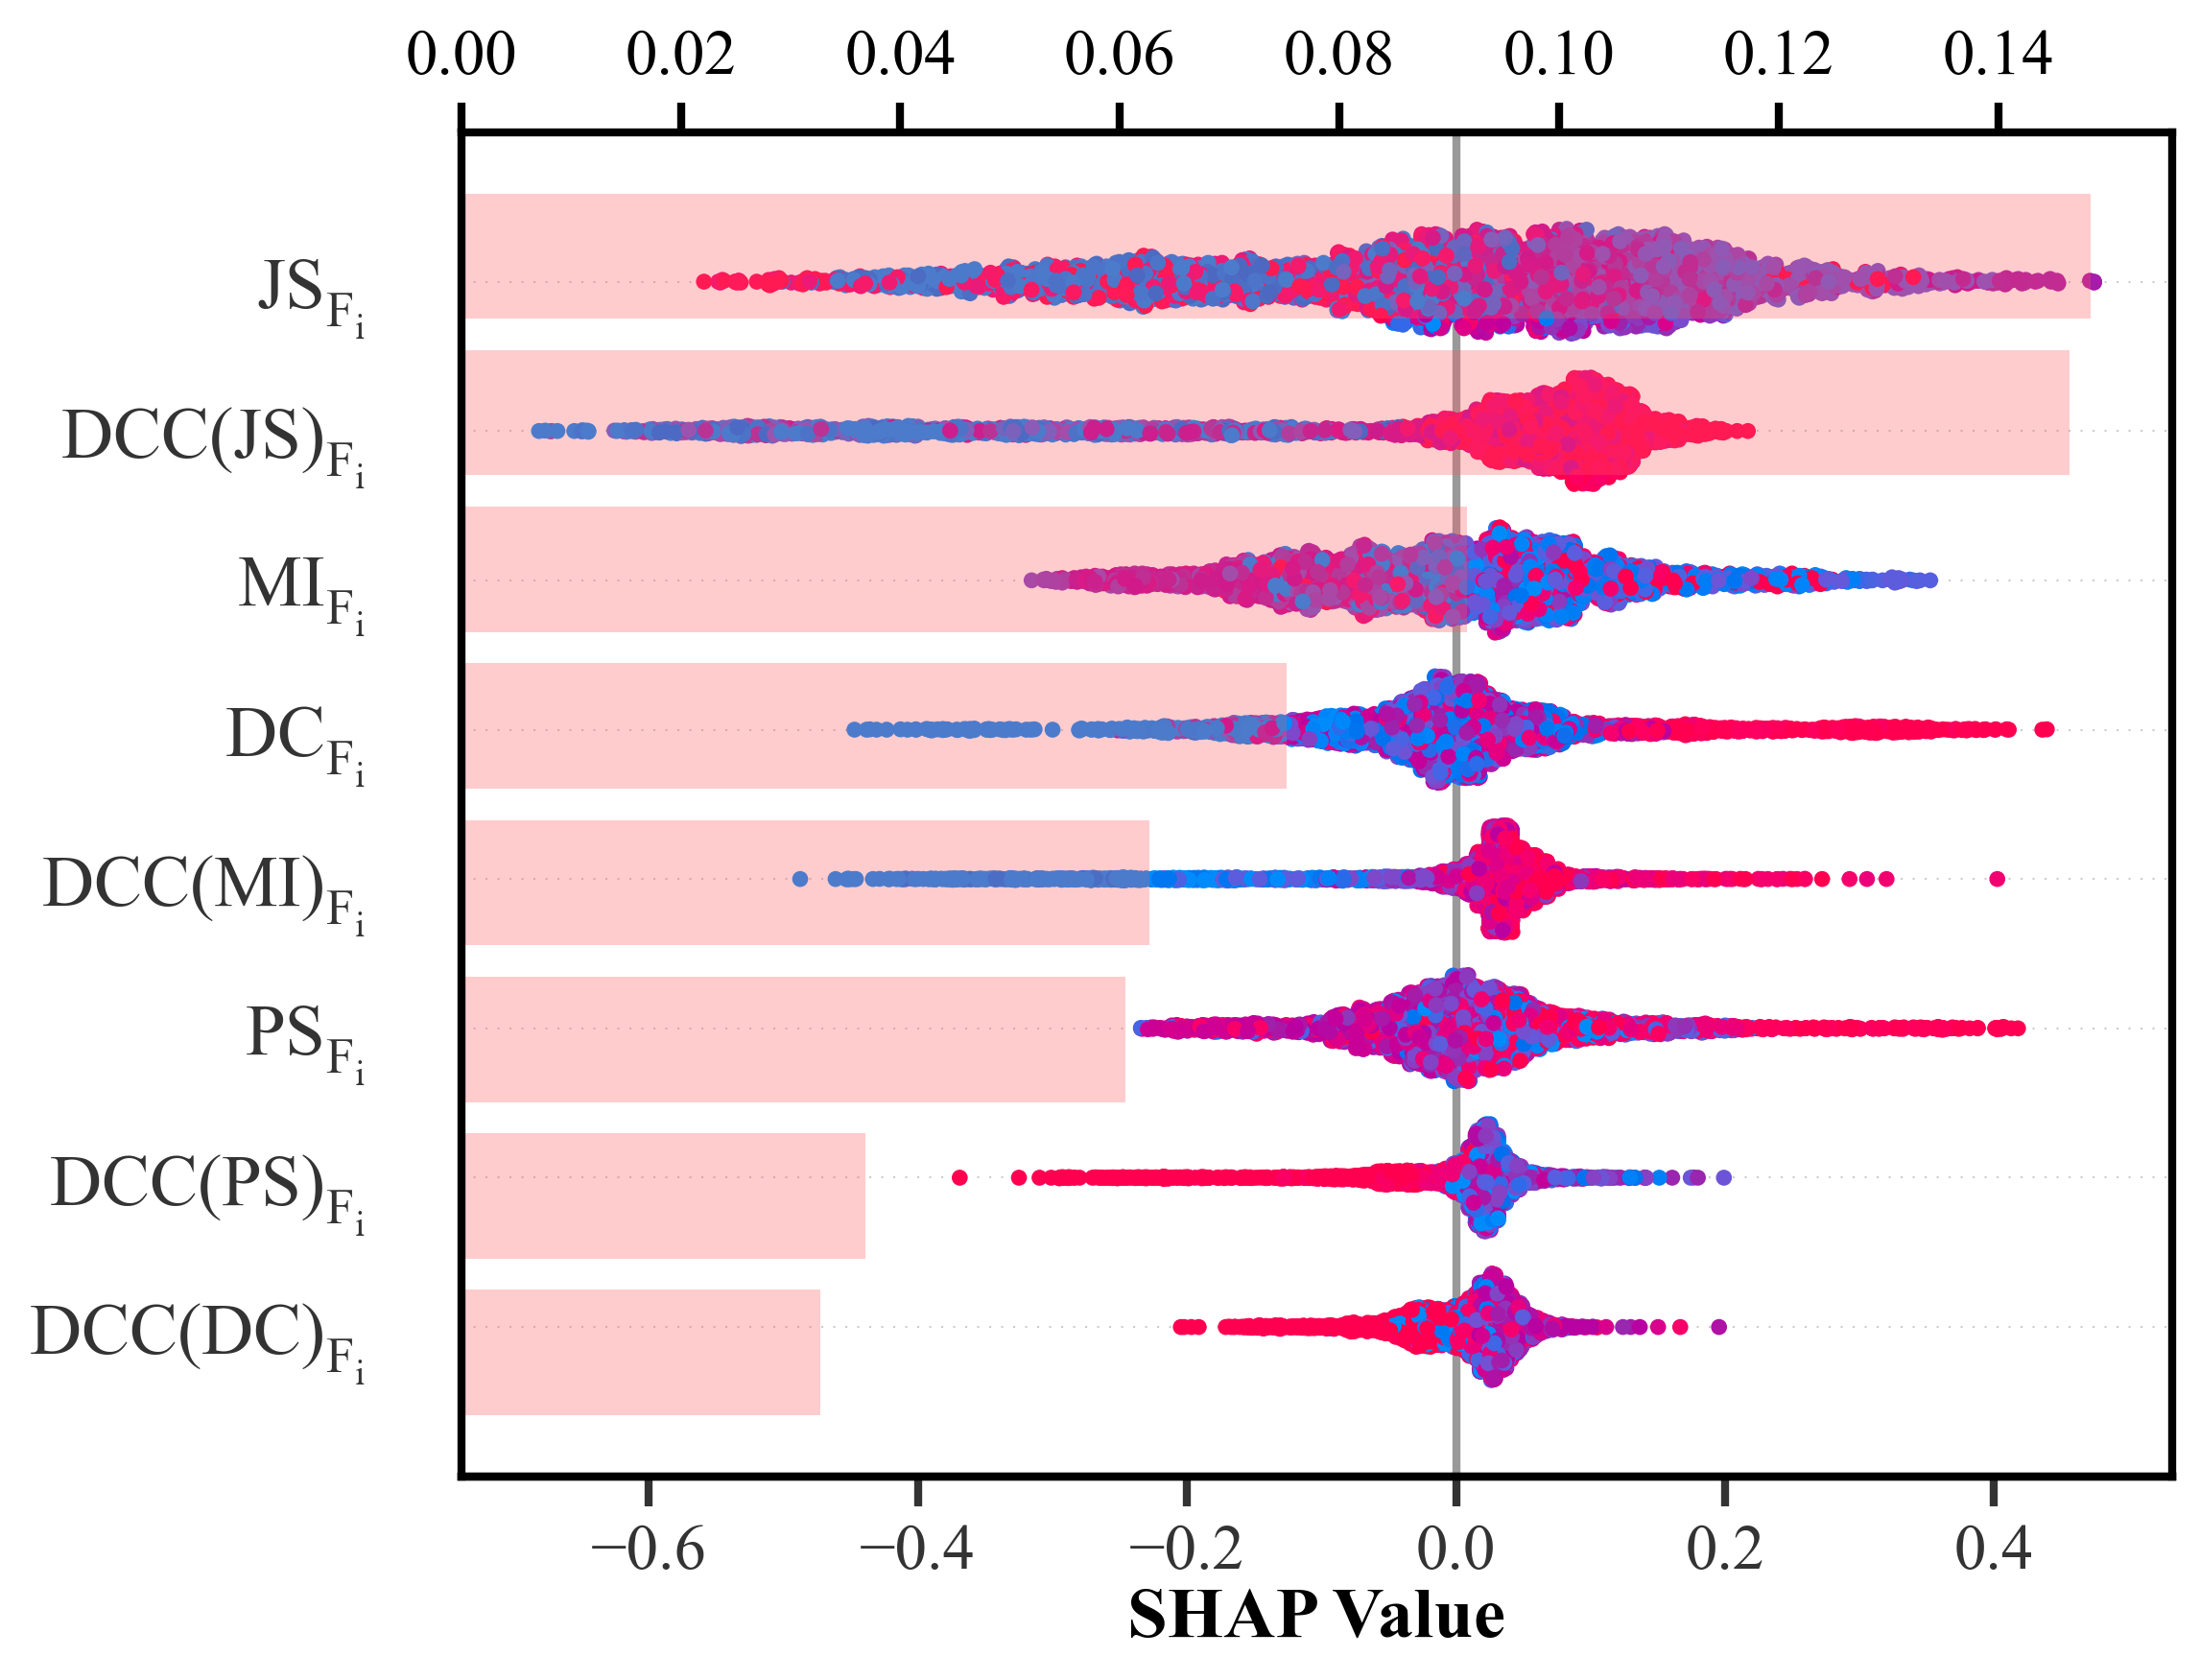

In [20]:
# ========== SHAP 合并画图 ==========
# 合并所有折的 SHAP 值和输入
shap_values_concat = np.concatenate(shap_values_all, axis=0)
X_concat = pd.concat(X_all, axis=0)

fig, ax1 = plt.subplots(figsize=(8, 6))

max_display = len(X_cols)

# ===== 绘制 SHAP 点图 =====
shap.summary_plot(
    shap_values_concat, 
    X_concat, 
    show=False, 
    color_bar=False,
    max_display=max_display,
)

# 计算默认特征重要性顺序（用于排序）
mean_abs_shap = np.abs(shap_values_concat).mean(axis=0)
sort_idx = np.argsort(mean_abs_shap)[::-1]
feature_names = X_concat.columns[sort_idx].tolist()
print("Default feature order:", feature_names)

# 替换为自定义名称
custom_names_dict = {
    "SHAP_feat": r"$SHAP_{F_{i}}$",
    "SHAP_feat_ratio": r"$SHAP_{F_{i}} \%$",
    "perturbation_type": r"$\theta$",
    "perturbation_ratio": r"$\theta$",
    "DCC_pearson_matrix": r"$DCC(PS)_{F_{i}}$",
    "DCC_spearman_matrix": r"$DCC(SP)_{F_{i}}$",
    "DCC_kendall_matrix": r"$DCC(KD)_{F_{i}}$",
    "DCC_mutual_info_matrix": r"$DCC(MI)_{F_{i}}$",
    "DCC_js_corr_matrix": r"$DCC(JS)_{F_{i}}$",
    "DCC_wd_corr_matrix": r"$DCC(WD)_{F_{i}}$",
    "DCC_xi_matrix": r"$DCC(XI)_{F_{i}}$",
    "DCC_dcor_matrix": r"$DCC(DC)_{F_{i}}$",
    "Corr_pearson_matrix": r"$PS_{F_{i}}$",
    "Corr_spearman_matrix": r"$SP_{F_{i}}$",
    "Corr_kendall_matrix": r"$KD_{F_{i}}$",
    "Corr_mutual_info_matrix": r"$MI_{F_{i}}$",
    "Corr_js_corr_matrix": r"$JS_{F_{i}}$",
    "Corr_wd_corr_matrix": r"$WD_{F_{i}}$",
    "Corr_xi_matrix": r"$XI_{F_{i}}$",
    "Corr_dcor_matrix": r"$DC_{F_{i}}$",
}
custom_names = [custom_names_dict[col] for col in feature_names[:max_display]]
custom_names = list(reversed(custom_names))
print("Custom feature names:", custom_names)


plt.gca().tick_params(axis='x', labelsize=16)
plt.gca().set_xlabel("SHAP Value", fontsize=18)
plt.gca().set_yticklabels(custom_names, fontsize=18)

# ===== 绘制 SHAP 条形图 =====
ax2 = ax1.twiny()
bar_heights = mean_abs_shap[sort_idx][::-1]
ax2.barh(
    np.arange(max_display),
    bar_heights[:max_display],
    alpha=0.3,
)

# 调整布局
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.savefig("plots/shap_fi_ratio_summary.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
def feat_rank(feat_ratio):
    if feat_ratio < 0.1:
        return "Low"
    elif feat_ratio < 0.5:
        return "Medium"
    elif feat_ratio < 0.9:
        return "High"
    else:
        return "Very High"

In [22]:
df["feat_rank"] = df["SHAP_feat_ratio"].apply(feat_rank)
df

C:\Users\11946\AppData\Local\Temp\ipykernel_10776\461711431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["feat_rank"] = df["SHAP_feat_ratio"].apply(feat_rank)


SHAP_feat  SHAP_feat_ratio  Corr_pearson_matrix  \
0      0.031496         0.297431            -0.100841   
1      0.027763         0.262175            -0.395085   
2      0.036863         0.348111            -0.094558   
3      0.026647         0.251633            -0.246314   
4      0.009097         0.085910             0.017028   
...         ...              ...                  ...   
4614   0.041932         0.396910             0.017525   
4616   0.007102         0.067225             0.226079   
4617   0.018134         0.171648            -0.229745   
4618   0.019256         0.182265             0.321769   
4619   0.032851         0.310950            -0.169058   

      Corr_mutual_info_matrix  Corr_js_corr_matrix  Corr_dcor_matrix  \
0                    0.024555             0.313147          0.135073   
1                    0.077559             0.528265          0.377583   
2                    0.091084             0.320797          0.175186   
3                    0.025397             0.390185          0.253483   
4                    0.012468             0.547022          0.074559   
...                       ...                  ...               ...   
4614                 0.110179             0.378569          0.175821   
4616                 0.137900             0.371876          0.296191   
4617                 0.102717             0.230718          0.274572   
4618                 0.130991             0.205769          0.323027   
4619                 0.115994             0.278359          0.259084   

      DCC_pearson_matrix  DCC_mutual_info_matrix  DCC_js_corr_matrix  \
0               1.000000                1.000000            1.000000   
1               0.928571                0.928571            1.000000   
2               0.928571                1.000000            1.000000   
3               0.928571                1.000000            1.000000   
4               1.000000                1.000000            1.000000   
...                  ...                     ...                 ...   
4614            0.523810                0.952381            0.952381   
4616            0.904762                0.904762            0.809524   
4617            0.333333                0.952381            0.904762   
4618            0.714286                0.952381            0.904762   
4619            0.666667                0.952381            0.857143   

      DCC_dcor_matrix feat_rank  
0            1.000000    Medium  
1            1.000000    Medium  
2            1.000000    Medium  
3            1.000000    Medium  
4            1.000000       Low  
...               ...       ...  
4614         0.666667    Medium  
4616         0.904762       Low  
4617         0.571429    Medium  
4618         0.857143    Medium  
4619         0.809524    Medium  

[4235 rows x 11 columns]

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

df["feat_rank"] = LabelEncoder().fit_transform(df["feat_rank"])
X = df.drop(columns=["SHAP_feat", "SHAP_feat_ratio", "feat_rank"])
y = df["feat_rank"]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
y_trues = []
y_preds = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=500, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    y_trues.extend(y_test.tolist())
    y_preds.extend(preds.tolist())
    results.append(accuracy_score(y_test, preds))
print(f"Accuracy: {np.mean(results):.4f} ± {np.std(results):.4f}")

C:\Users\11946\AppData\Local\Temp\ipykernel_10776\1846932435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["feat_rank"] = LabelEncoder().fit_transform(df["feat_rank"])


Accuracy: 0.8638 ± 0.0065


Text(257.75, 0.5, 'True')

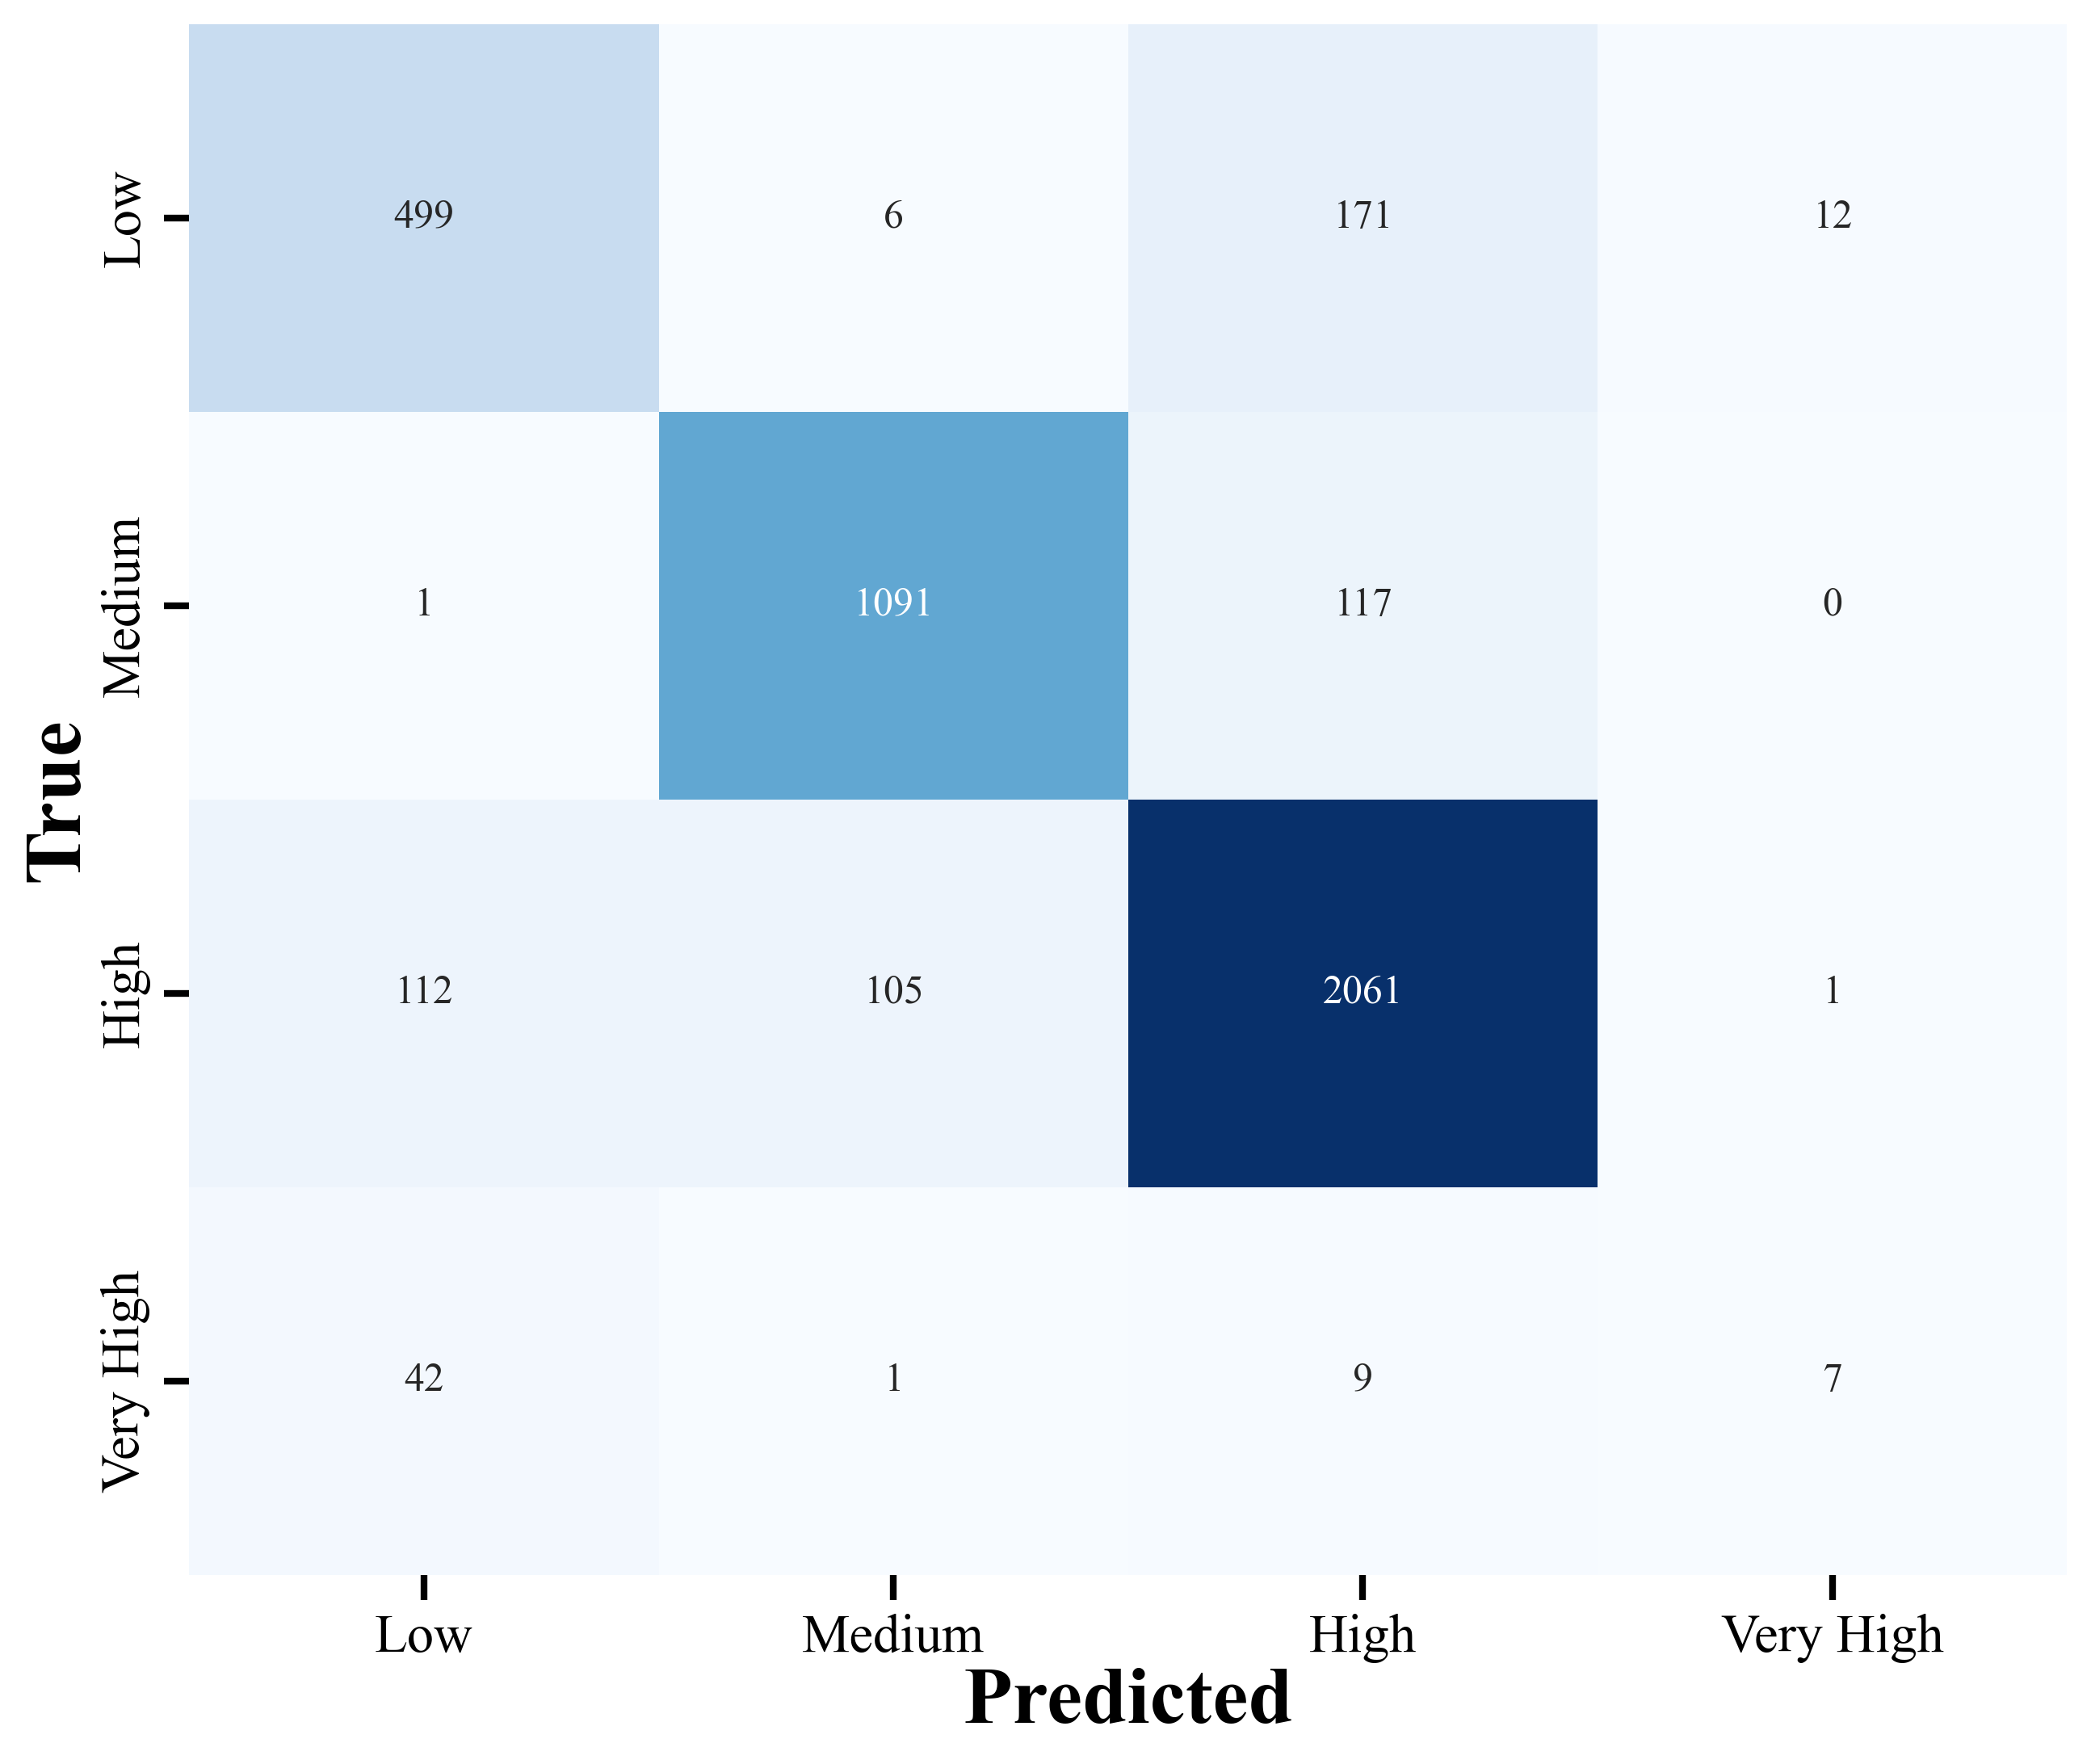

In [24]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_trues, y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High", "Very High"], yticklabels=["Low", "Medium", "High", "Very High"], cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")